# Analysis of the cost recovery of user engagement

***Introduction***

In this project, we need to draw a conclusion about the success of advertising costs, how successful attracting users is, how many of them turn into paying users, how many continue to use the application.

In this project, we have three tables with information about site visits, orders and advertising costs. These tables contain information about users, their use of the application - from which devices, in which regions, from which advertising channels they came, information about their sessions in the application.

During the analysis process, it will be necessary to understand which advertising channels users come from, which devices they use, analyze the costs of various advertising channels, understand how much each client actually brings, when the cost of attracting a client pays off, and what factors hinder customer attraction.

To complete the task, it is necessary to study the data, prepare functions for calculating the necessary indicators, analyze the data - create user profiles, find out which regions are the most popular among them, which devices they use to log into applications, how they came to the application. Next, it is necessary to analyze how successful the actions of the marketing department are and see which channels of attraction funds are spent on, how much the users of the application who came from advertising bring, how much it cost to attract users, estimate how much they bring to the company after using the application. And in the end, we have to see if the marketing costs are paying off or whether it is worth reviewing their distribution. To draw a conclusion based on the conducted research.

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

visits = pd.read_csv('visits_info_short.csv')
orders = pd.read_csv('orders_info_short.csv')
costs = pd.read_csv('costs_info_short.csv')

In [5]:
visits.info()
visits = visits.rename(columns={'User Id':'user_id', 'Session Start':'session_start', 'Session End':'session_end',\
                                'Region':'region', 'Device':'device','Channel':'channel'})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [6]:
 visits.duplicated().sum()

0

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [8]:
orders.info()
orders = orders.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt','Revenue':'revenue'})


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [9]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [10]:
orders.duplicated().sum()

0

In [11]:
costs.info()
costs = costs.rename(columns={'Channel':'channel'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [12]:
print(costs)

              dt         channel  costs
0     2019-05-01        FaceBoom  113.3
1     2019-05-02        FaceBoom   78.1
2     2019-05-03        FaceBoom   85.8
3     2019-05-04        FaceBoom  136.4
4     2019-05-05        FaceBoom  122.1
...          ...             ...    ...
1795  2019-10-23  lambdaMediaAds    4.0
1796  2019-10-24  lambdaMediaAds    6.4
1797  2019-10-25  lambdaMediaAds    8.8
1798  2019-10-26  lambdaMediaAds    8.8
1799  2019-10-27  lambdaMediaAds   12.0

[1800 rows x 3 columns]


In [13]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [14]:
costs.duplicated().sum()

0

In [15]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

No gaps were found in the data. No obvious duplicates were found in the data. The columns with date and time data in all tables are adjusted to the desired data type.

In [16]:
def get_profiles(visits, orders, costs, event_names=[]):

    # sort sessions by user ID and engagement date
    # group by ID and find the parameters of the first visits
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # let's call the time of the first visit as first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # returning the user_id from the index
    )

    # for cohort analysis, we determine the date of the first visit
    # and the first day of the month in which this visit took place
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # adding a sign of paying users
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # adding flags for all events from event_names
    #for event in event_names:
        #if event in events['event_name'].unique():
            # we check if each user is dating
            # among those who made the event event
            #profiles[event] = profiles['user_id'].isin(
                #events.query('event_name == @event')['user_id'].unique()
            #)

   # counting the number of unique users
   # with the same source and date of attraction
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # let's call the column with the number of users as unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # returning dt and channel from the indexes
    )

    # we combine spending on advertising and the number of attracted users
    # by date and channel of attraction
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # we divide the advertising costs by the number of attracted users
    # we will save the results in the acquisition_cost (CAC) column
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # add the cost of attraction to the profiles
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles
    


In [17]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head())

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [18]:
observation_date = datetime(2019, 10, 1).date()  
print(observation_date)
horizon_days = 14

2019-10-01


In [19]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # decide which columns we will leave for the retention grouping, the column of the sign of the paying user always remains
    dimensions = ['payer'] + dimensions
    
    # cut off all users who could not "live" to the desired horizon
    # (joined later than observation_date - horizon)
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    retention_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # creating an array of raw data
    retention_raw = retention_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    retention_raw['lifetime'] = (retention_raw['session_start'] - retention_raw['first_ts']).dt.days
    
    # the function of grouping by the desired set of measurements
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     # building a "triangular table" 
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) # determine the size of the cohorts
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   # attach the cohort sizes to the triangular table
        result = result.div(result['cohort_size'], axis = 0)                                                     # divide each of the columns by the size of the cohort - calculate the retention rate
        result = result[['cohort_size'] + list(range(horizon_days))]                                             # leave only observations to the desired horizon and a column of cohort sizes
        result['cohort_size'] = cohort_sizes                                                                     # re-assign the column of cohort sizes, because during the division it turned into 1
        return result
    # calculating retention
    retention_grouped = group_by_dimensions(retention_raw, dimensions, horizon_days)
    
    # calculate the retention in all parameters + date
    retention_in_time = group_by_dimensions(retention_raw, dimensions + ['dt'], horizon_days)
    
    # return both retention tables and raw data (so that if anything happens, you can dig into them during debugging)
    return retention_raw, retention_grouped, retention_in_time

  


In [20]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles, visits, observation_date, horizon_days, dimensions = [])

In [21]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # exclude users who have not "lived up" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # adding data about purchases in the profile
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # calculate the user's lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # group by cohort if there is nothing in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # grouping function by desired attributes
    def group_by_dimensions(df, dims, horizon_days):
        # building a "triangular" revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # find the amount of revenue with accumulation
        result = result.fillna(0).cumsum(axis=1)
        # calculate the size of the cohorts
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # combine the cohort sizes and the revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # counting LTV: dividing each "cell" in a row by the size of the cohort
        result = result.div(result['cohort_size'], axis=0)
        # exclude all lifetimes exceeding the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restoring cohort sizes
        result['cohort_size'] = cohort_sizes

        # saving user data and CAC values to the dataframe,
        # adding parameters from dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # calculate the average CAC according to the parameters from dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # counting ROI: dividing LTV by CAC
        roi = result.div(cac['cac'], axis=0)

        # deleting rows with infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # restoring the cohort sizes in the ROI table
        roi['cohort_size'] = cohort_sizes

        # adding CAC to the ROI table
        roi['cac'] = cac['cac']

        # in the final table, we leave the cohort sizes, CAC
        # and ROI in lifetimes that do not exceed the analysis horizon
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # return the LTV and ROI tables
        return result, roi

    # get the LTV and ROI tables
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # for dynamics tables, we remove the 'cohort' from dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # get tables of LTV and ROI dynamics
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # raw data
        result_grouped,  # LTV table
        result_in_time,  # LTV dynamics table
        roi_grouped,  # ROI table
        roi_in_time,  # ROI dynamics table
    )

In [22]:
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(profiles, orders, observation_date,horizon_days, dimensions=[], ignore_horizon=False)

In [23]:
def get_conversion(
    profiles,
    purchases, 
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # Step 1. Get user profiles and purchase data
    # passing them as the profiles and purchases arguments

    # exclude users who have not "lived up" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    conversion_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # Step 2. Find the date and time of the first purchase for each user
    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # Step 3. Add purchase data to profiles
    conversion_raw = conversion_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # Step 4. Calculate the lifetime for each purchase
    conversion_raw['lifetime'] = (
        conversion_raw['event_dt'] - conversion_raw['first_ts']
    ).dt.days
    # will use this column for grouping in the case when nothing is passed to dimensions
    if len(dimensions) == 0:
        conversion_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']  

    # a function for grouping a table by desired attributes
    def group_by_dimensions(df, dims, horizon_days):

        # Step 5. Build a conversion table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )

        # Step 6. Calculate the cumulative amount for each row
        result = result.fillna(0).cumsum(axis = 1)

        # Step 7. Calculate cohort sizes
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Step 8. Combine the cohort size and conversion tables
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Step 9. Divide each "cell" in a row by the size of the cohort
        result = result.div(result['cohort_size'], axis=0)

        # exclude all lifetimes exceeding the analysis horizon
        result = result[['cohort_size'] + list(range(horizon_days))]
        # restoring cohort sizes
        result['cohort_size'] = cohort_sizes
        return result

    # get the conversion table
    conversion_grouped = group_by_dimensions(conversion_raw, dimensions, horizon_days)

    # get a table of conversion dynamics
    conversion_in_time = group_by_dimensions(
        conversion_raw, dimensions + ['dt'], horizon_days
    )

    # return both tables and raw data
    return conversion_raw, conversion_grouped, conversion_in_time 

In [24]:
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(profiles, orders, observation_date, horizon_days)

In [25]:
def filter_data(df, window):
    # apply a moving average for each column
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [26]:
def plot_retention(retention, retention_history, horizon):

    # setting the grid size for the graphs
    plt.figure(figsize=(30, 15))

    # exclude cohort sizes and retention of the first day
    retention = retention.drop(columns=['cohort_size', 0])

    # if only payer is in the retention table indexes,
    # adding the second attribute — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # the graph table has two columns and two rows, four cells
    # in the first one, we build retention curves for paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    # in the second cell, we build retention curves for non-paying customers
    # the vertical axis is from the graph from the first cell
    ax2 = plt.subplot(2, 2, 2, sharey = ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of not paying users')

    # in the third cell, the dynamics of retention of payers
    ax3 = plt.subplot(2, 2, 3)
    # getting the column names for the pivot table
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filter the data, build a summary table and a graph based on it
    retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon-1, aggfunc='mean'
    ).plot(grid=True, ax=ax3)
    plt.xlabel('Date of attraction')
    plt.title(
        'Dynamics of retention of paying users on the {}th day'.format(
            horizon
        )
    )
    
    # in the fourth cell, the dynamics of non—paying retention
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    # filter the data, build a summary table and a graph based on it
    retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    ).plot(grid=True, ax=ax4)
    plt.xlabel('Date of attraction')
    plt.title(
        'Dynamics of retention of non-paying users on the {}th day'.format(
            horizon
        )
    )

    # exclude the overlapping of graphs on each other
    plt.tight_layout()

    plt.show()



In [27]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # setting the grid size for the graphs
    plt.figure(figsize=(30, 15))

    # exclude cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # leave only the necessary lifetime in the dynamics table
    conversion_in_time = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # The first graph is conversion curves
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('User Conversion rate')

    # The second graph is the conversion dynamics
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # all columns of the index, except the date, will become columns of the pivot table
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of attraction')
    plt.title('The dynamics of user conversion on the {}th day'.format(horizon))

    plt.tight_layout()
    plt.show()
 

In [39]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(30, 20))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # The first graph is ltv curves
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # The second graph is the dynamics of ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of attraction')
    plt.title('Dynamics of LTV users on the {}th day'.format(horizon))

    # The third graph is the dynamics of cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of attraction')
    plt.title('Dynamics of the cost of attracting users')

    # The fourth graph is the ROI curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # The fifth chart is the dynamics of ROI
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.xlabel('Date of attraction')
    plt.title('Dynamics of user ROI on the {}th day'.format(horizon))

    plt.tight_layout()
    plt.show()

In [29]:
# create profiles and calculate the minimum and maximum dates
profiles = get_profiles(visits, orders, costs)
print(profiles.head())

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [30]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
print(min_date)
print(max_date)

2019-05-01
2019-10-27


The first users were attracted on the first of May 2019, the last ones on October 27, 2019, that is, the interval for analysis will be slightly less than six months.

In [31]:
regions = profiles.pivot_table(index = 'region', values='user_id', aggfunc='count')
payers = profiles.query('payer == True').pivot_table(index='region', values='user_id', aggfunc='count')
regions['percent'] = payers/regions
#print(payers)
#print(regions.sort_values(by='user_id', ascending=False))

Most of the users come from the USA, perhaps this is due to the fact that the population in the USA is larger than in other countries. From the USA, the highest share of paying users is 7%, from Germany it is slightly less - 4%

In [32]:
devices=profiles.pivot_table(index='device', values='user_id', aggfunc='count') 
devices_payers = profiles.query('payer == True').pivot_table(index='device', values='user_id', aggfunc='count')
devices['percent']=devices_payers/devices
print(devices.sort_values(by='user_id', ascending=False))

         user_id   percent
device                    
iPhone     54479  0.062079
Android    35032  0.058518
PC         30455  0.050468
Mac        30042  0.063644


Most users prefer the iPhone to use the app. But the majority of paying users are those who use a Mac, almost 6.4%, with iPhone users in second place by a very small margin - 6.2%

In [33]:
ads_channels=profiles.pivot_table(index='channel', values='user_id', aggfunc='count') 
ads_payers = profiles.query('payer == True').pivot_table(index='channel', values='user_id', aggfunc='count')
#print(ads_payers)
ads_channels['percent']=round(ads_payers*100/ads_channels, 2)
print(ads_channels.sort_values(by='percent', ascending=False))

                    user_id  percent
channel                             
FaceBoom              29144    12.20
AdNonSense             3880    11.34
lambdaMediaAds         2149    10.47
TipTop                19561     9.60
RocketSuperAds         4448     7.91
WahooNetBanner         8553     5.30
YRabbit                4312     3.83
MediaTornado           4364     3.57
LeapBob                8553     3.06
OppleCreativeMedia     8605     2.71
organic               56439     2.06


The majority of users come organically, it is more than 56 thousand users, nevertheless only 2% of these users are paying users. FaceBoom is one of the best channels for attracting users, it has brought 29 thousand users and is the most successful channel for attracting paying users, 12%. According to the number of attracted users, TipTop is in third place - 19.5 thousand users. And in terms of attracting paying users, Ad NonSense is in second place - 11%

### Marketing

In [34]:
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month
print(costs)

              dt         channel  costs  week  month
0     2019-05-01        FaceBoom  113.3    18      5
1     2019-05-02        FaceBoom   78.1    18      5
2     2019-05-03        FaceBoom   85.8    18      5
3     2019-05-04        FaceBoom  136.4    18      5
4     2019-05-05        FaceBoom  122.1    18      5
...          ...             ...    ...   ...    ...
1795  2019-10-23  lambdaMediaAds    4.0    43     10
1796  2019-10-24  lambdaMediaAds    6.4    43     10
1797  2019-10-25  lambdaMediaAds    8.8    43     10
1798  2019-10-26  lambdaMediaAds    8.8    43     10
1799  2019-10-27  lambdaMediaAds   12.0    43     10

[1800 rows x 5 columns]


In [35]:
sum_costs = costs['costs'].sum()
print('Total advertising costs:', sum_costs.round())

channel_costs = costs.pivot_table(index='channel', values='costs', aggfunc='sum')
print(channel_costs.sort_values(by='costs', ascending=False))

Total advertising costs: 105497.0
                       costs
channel                     
TipTop              54751.30
FaceBoom            32445.60
WahooNetBanner       5151.00
AdNonSense           3911.25
OppleCreativeMedia   2151.25
RocketSuperAds       1833.00
LeapBob              1797.60
lambdaMediaAds       1557.60
MediaTornado          954.48
YRabbit               944.22


It was concluded above that FaceBoom and TipTop show the best indicator for attracting paying users, and based on this table for the distribution of advertising costs, it is precisely these channels for attracting users that account for the highest costs

Text(0.5, 1.0, 'Cost allocation by month')

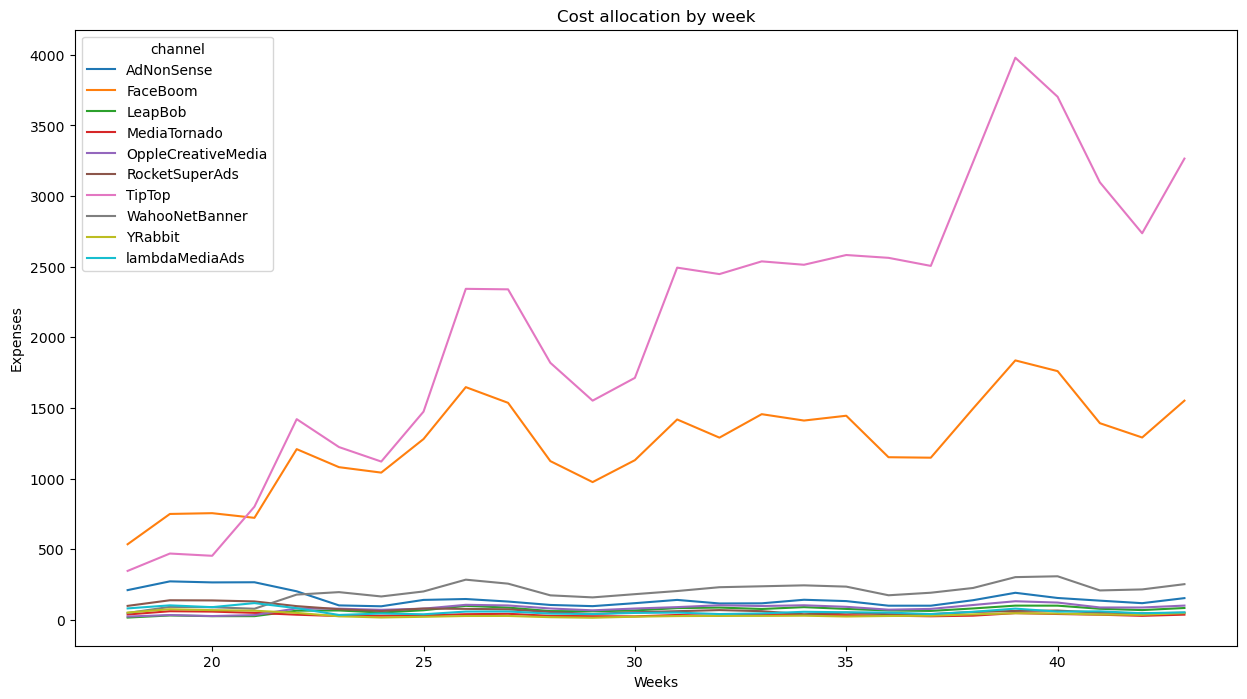

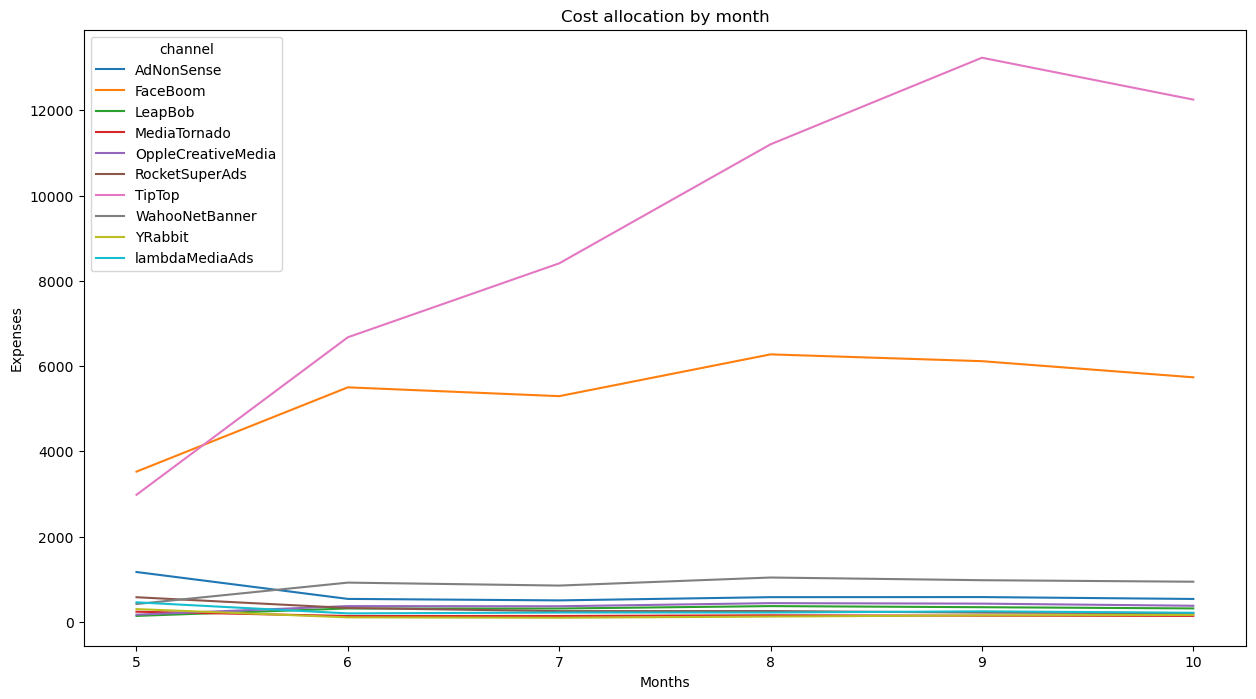

In [37]:
weekly_costs = costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
monthly_costs = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')

weekly_costs.plot(figsize=(15,8))
plt.xlabel('Weeks')
plt.ylabel('Expenses')
plt.title('Cost allocation by week')
monthly_costs.plot(figsize=(15,8))
plt.xlabel('Months')
plt.ylabel('Expenses')
plt.title('Cost allocation by month')

Advertising expenses on all channels, except FaceBoom and TipTop, do not undergo any special changes throughout the time, they are approximately at the same level, if you look at them by month, their level does not exceed 2000.
As for FaceBoom and TipTop, the costs of these channels increase over time, and they grow more noticeably on TipTop.

In [34]:
number_of_users = profiles['user_id'].count()
#print(number_of_users)
cac_total = profiles['acquisition_cost'].sum()
avg_cac_per_user = cac_total/number_of_users
print(avg_cac_per_user)

0.7032778251826568


In [35]:
avg_cac_per_channel = profiles.pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
print(avg_cac_per_channel.sort_values(by='acquisition_cost', ascending=False))

                    acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000


If we consider the average CAC for the entire project, it is 0.7, at the same time, separately by channels, it is 2.8 for TipTop, 1.1 for FaceBoom and 1 for AdNonSense, this is the top 3 in terms of recruitment costs.

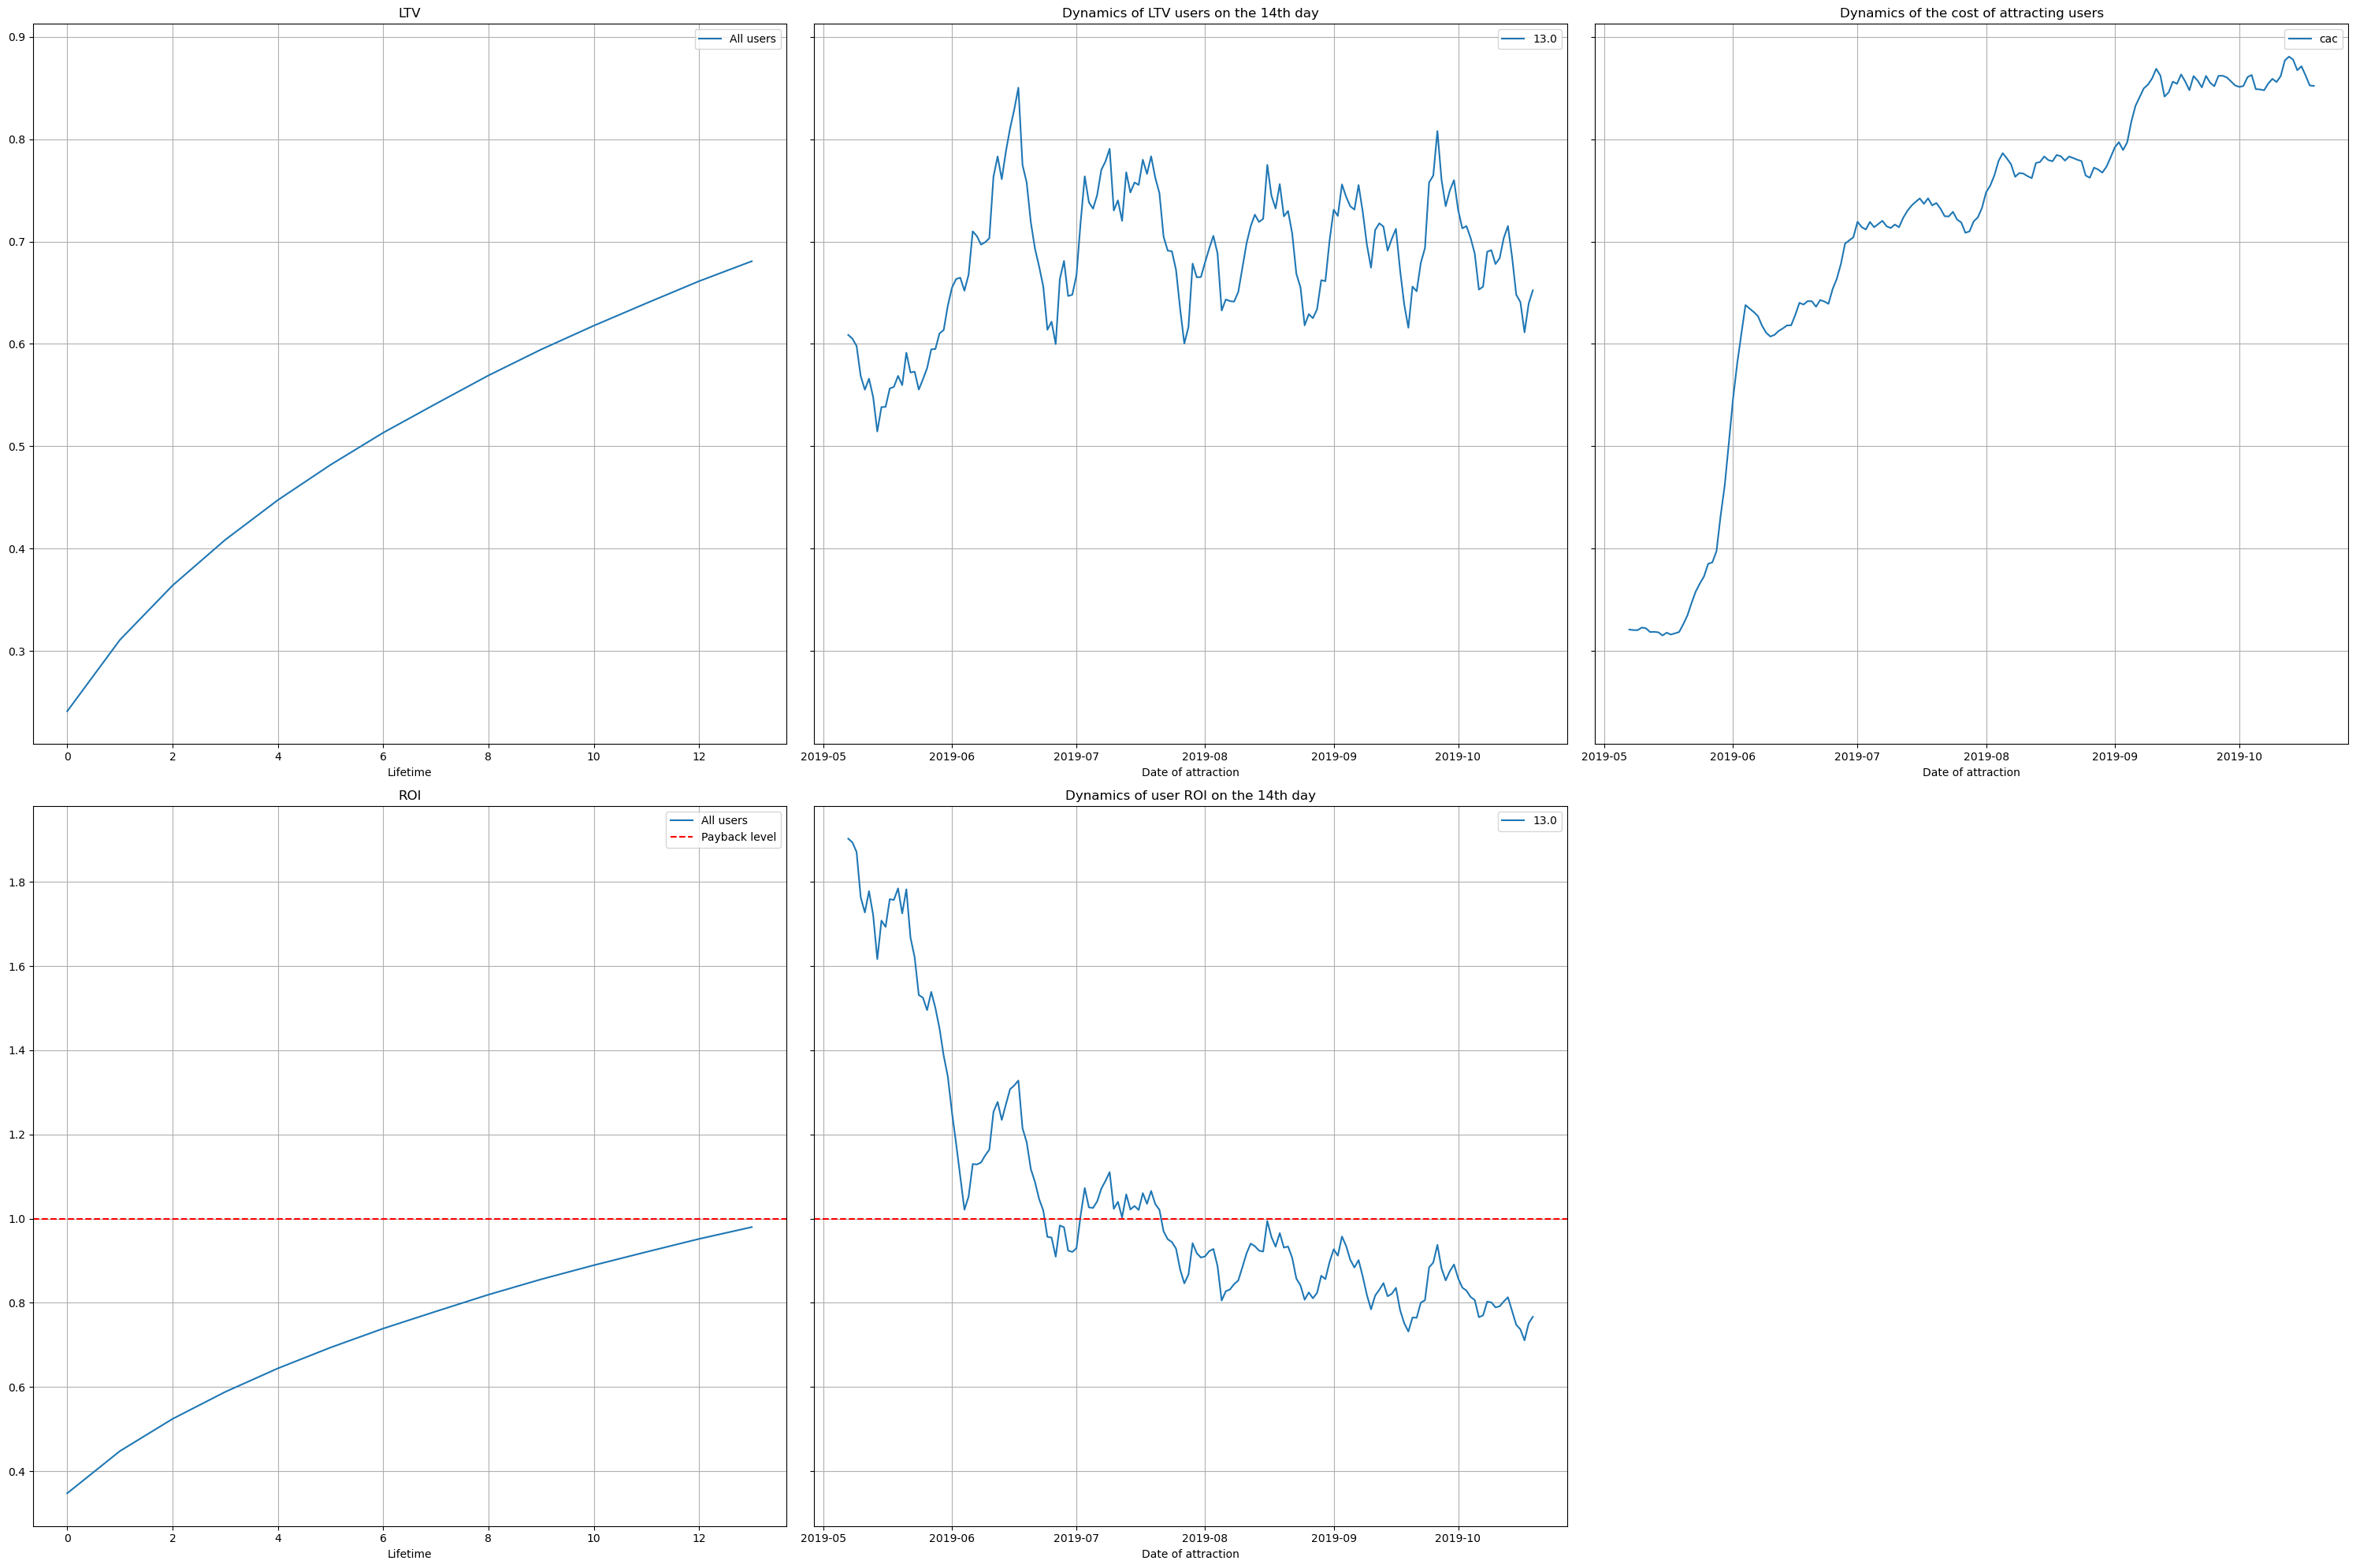

In [40]:
observation_date = datetime(2019, 11, 1).date()

horizon_days = 14



result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(profiles, orders, observation_date, horizon_days)

plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

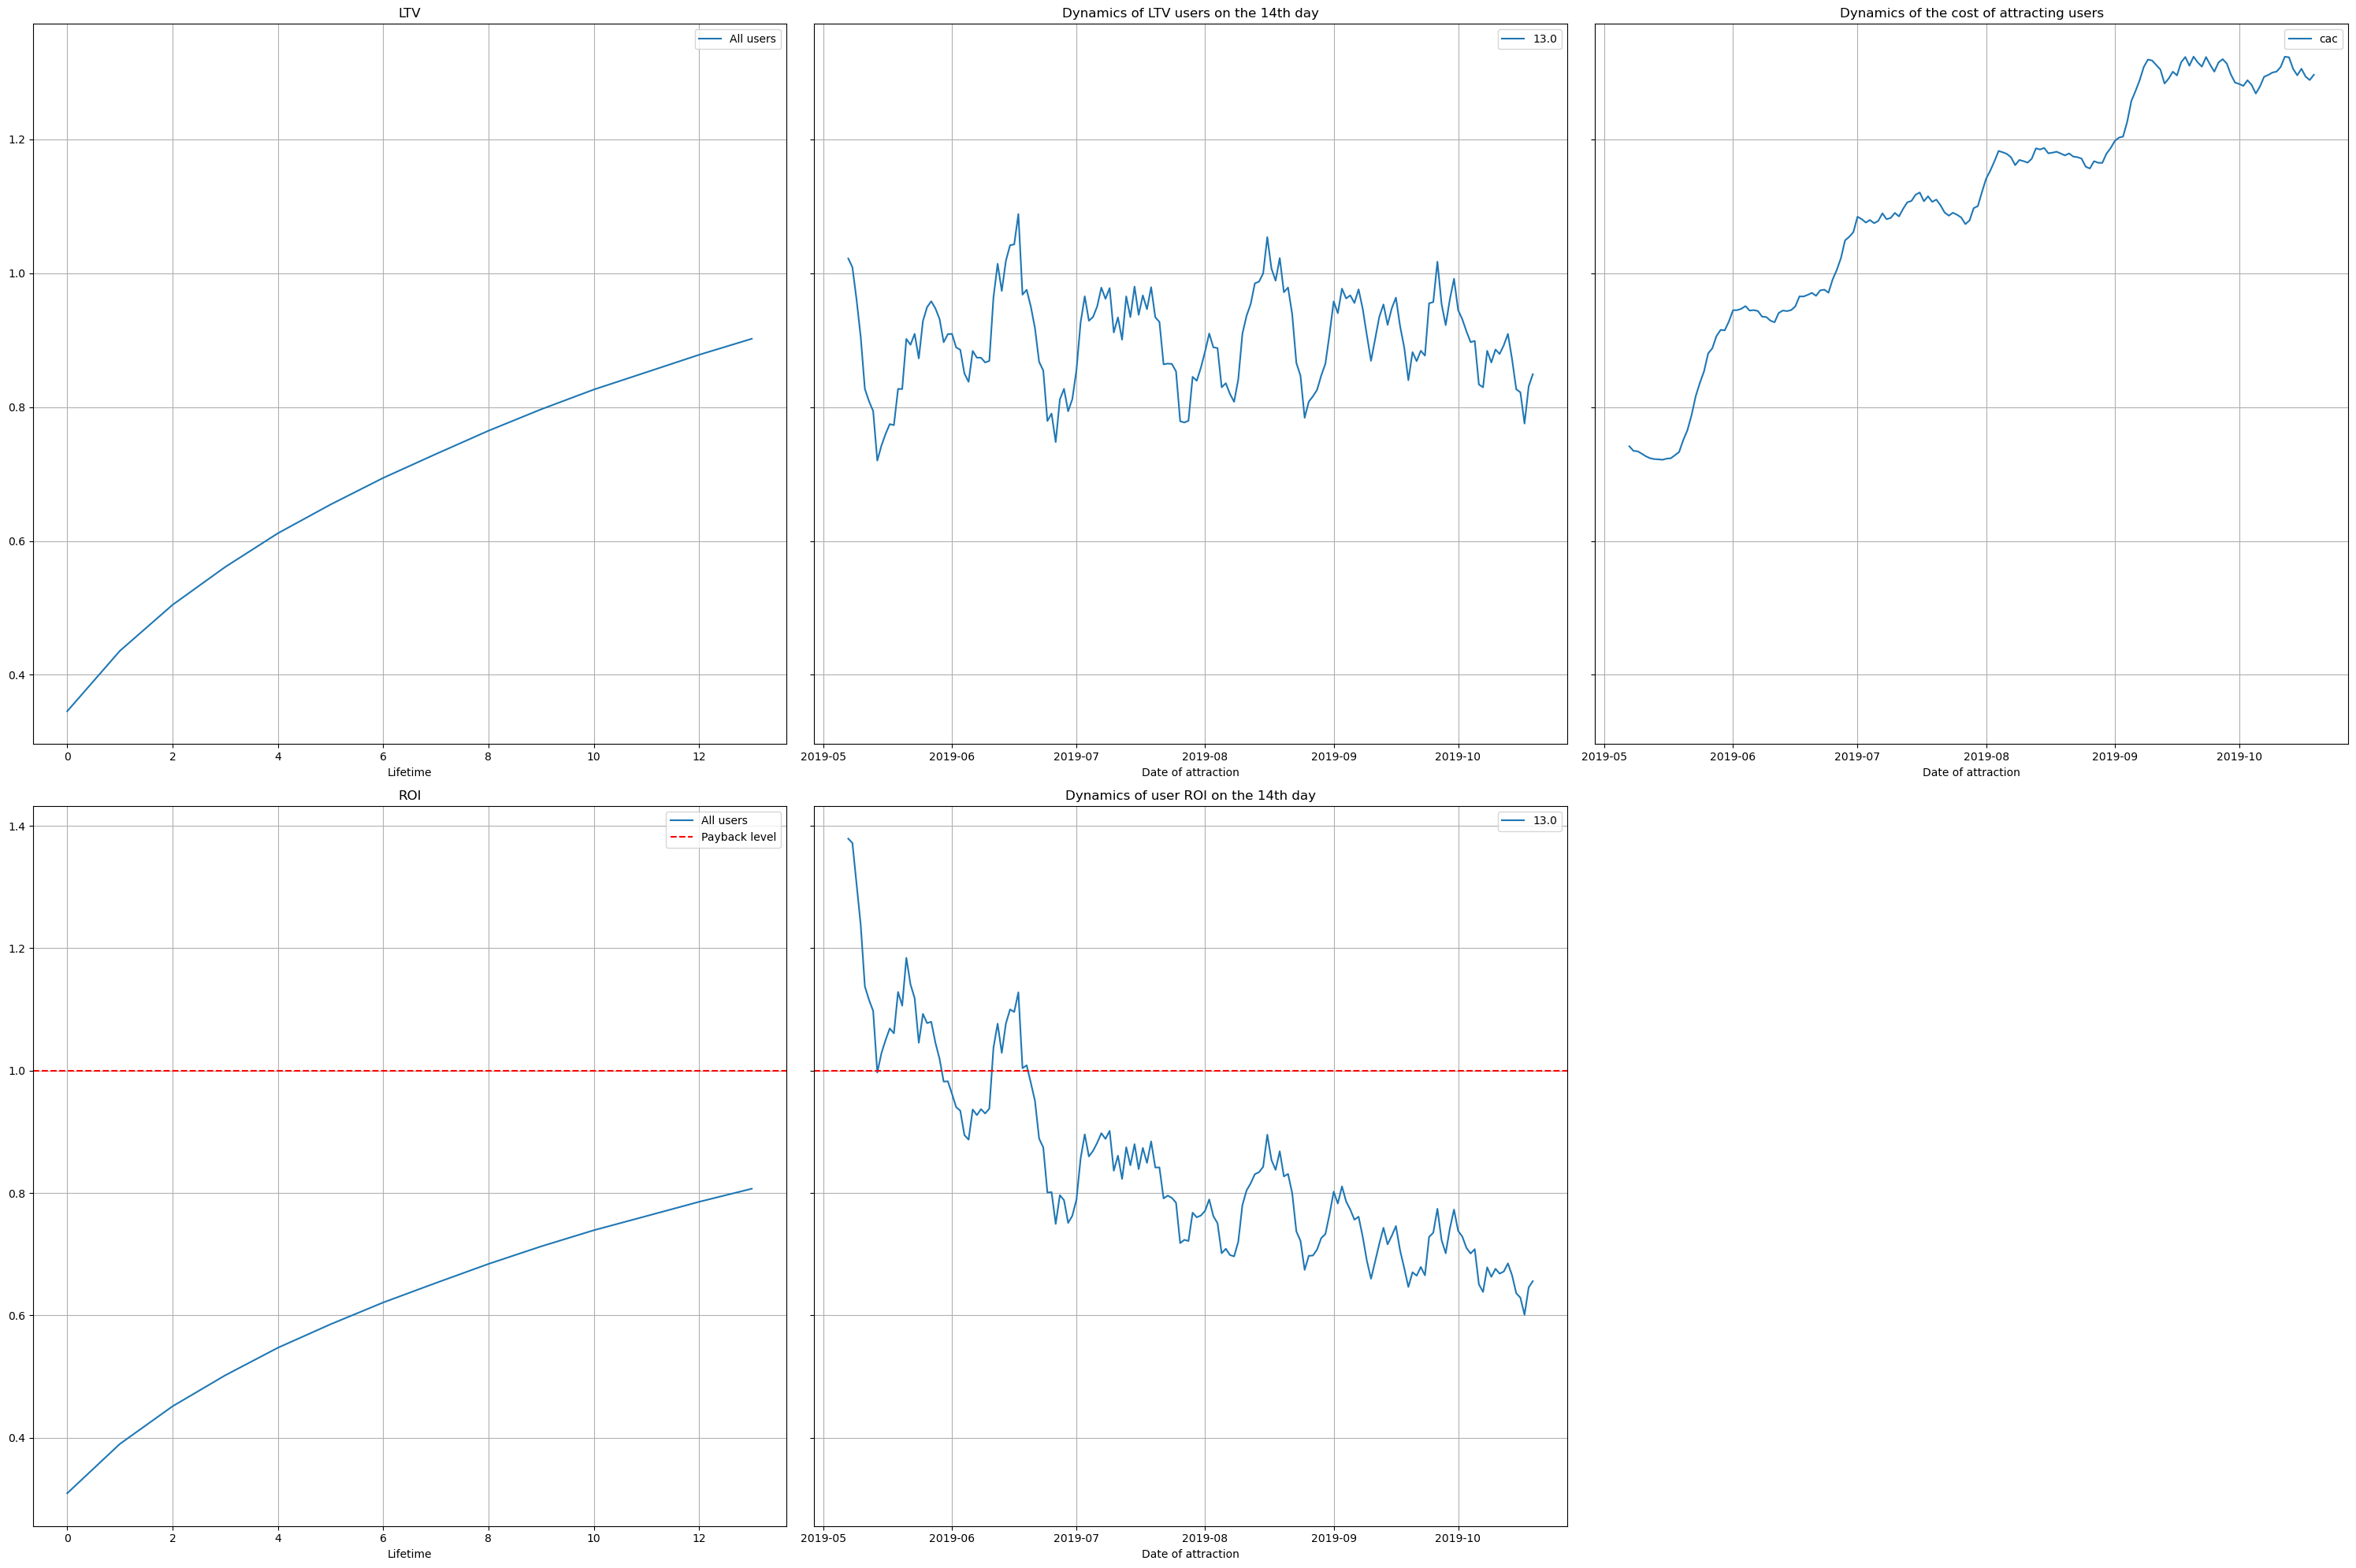

In [41]:
#excluding organic matter
profiles_no_orgnic = profiles.query('channel != "organic"')
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(profiles_no_orgnic, orders, observation_date, horizon_days)

plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

Advertising pays off if you rely on the ROI chart and its dynamics on the 14th day, it is extremely noticeable how by the 14th day the curve falls much below the payback level. In addition, the graph of the cost of attracting users demonstrates how much it is growing. LTV had a rather chaotic movement during the two weeks studied, and almost all the time the curve is below one.

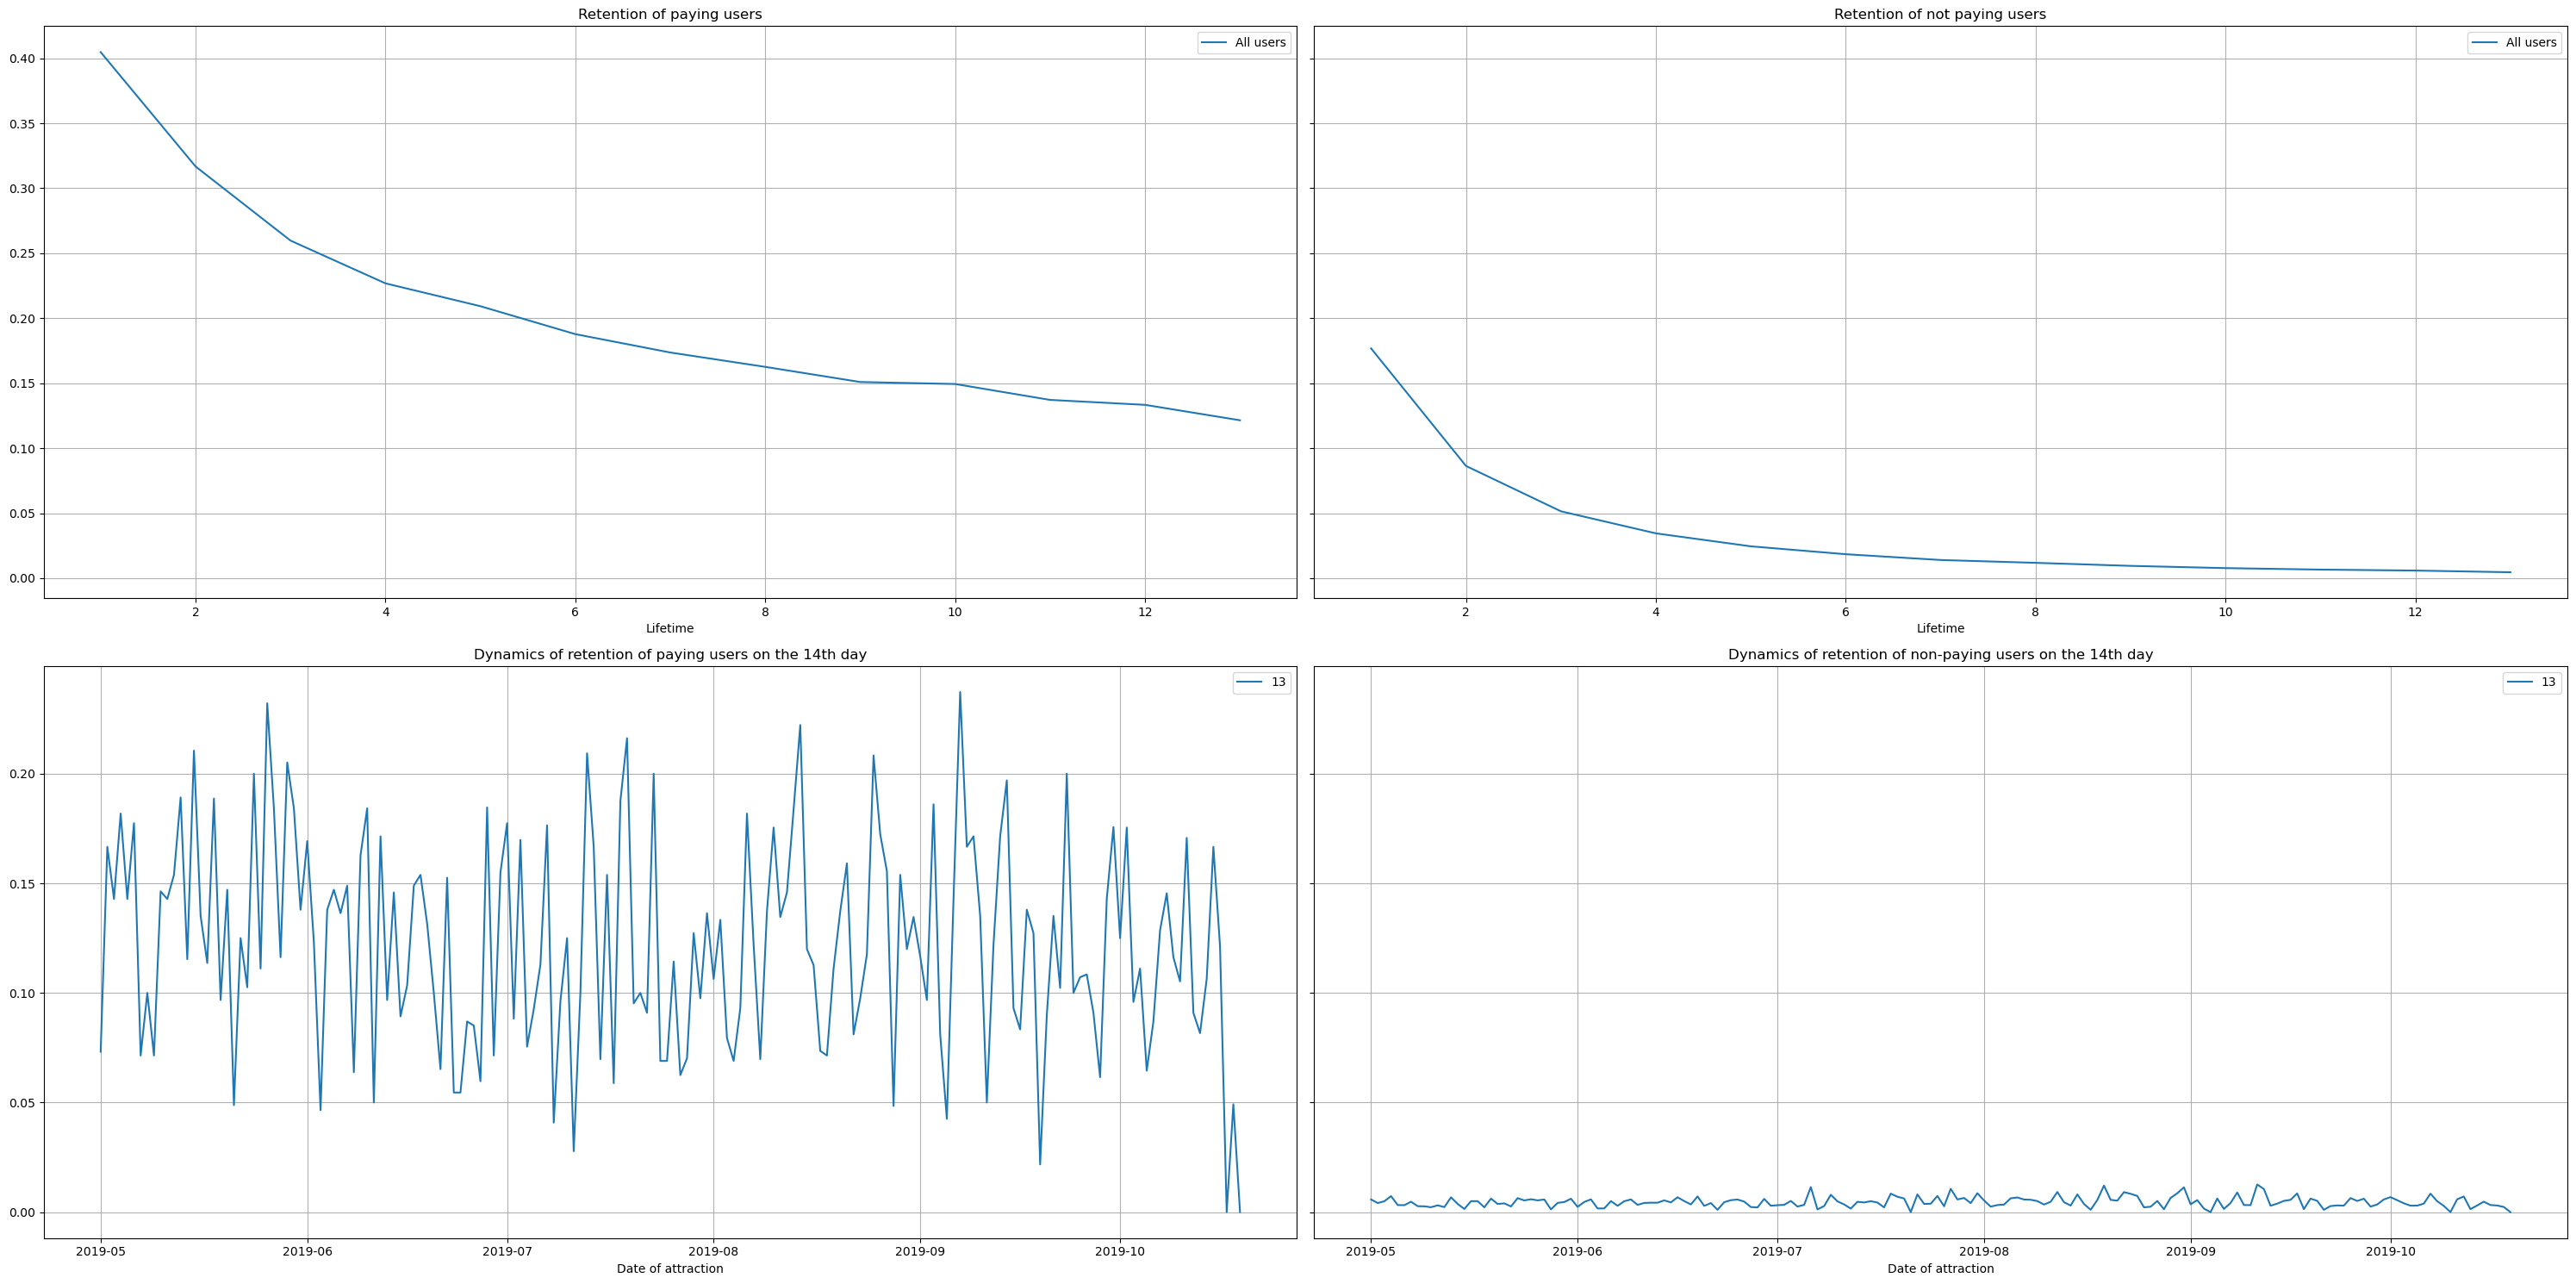

In [42]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles, visits, observation_date, horizon_days, dimensions = [])

plot_retention(retention_grouped, retention_in_time, horizon_days)

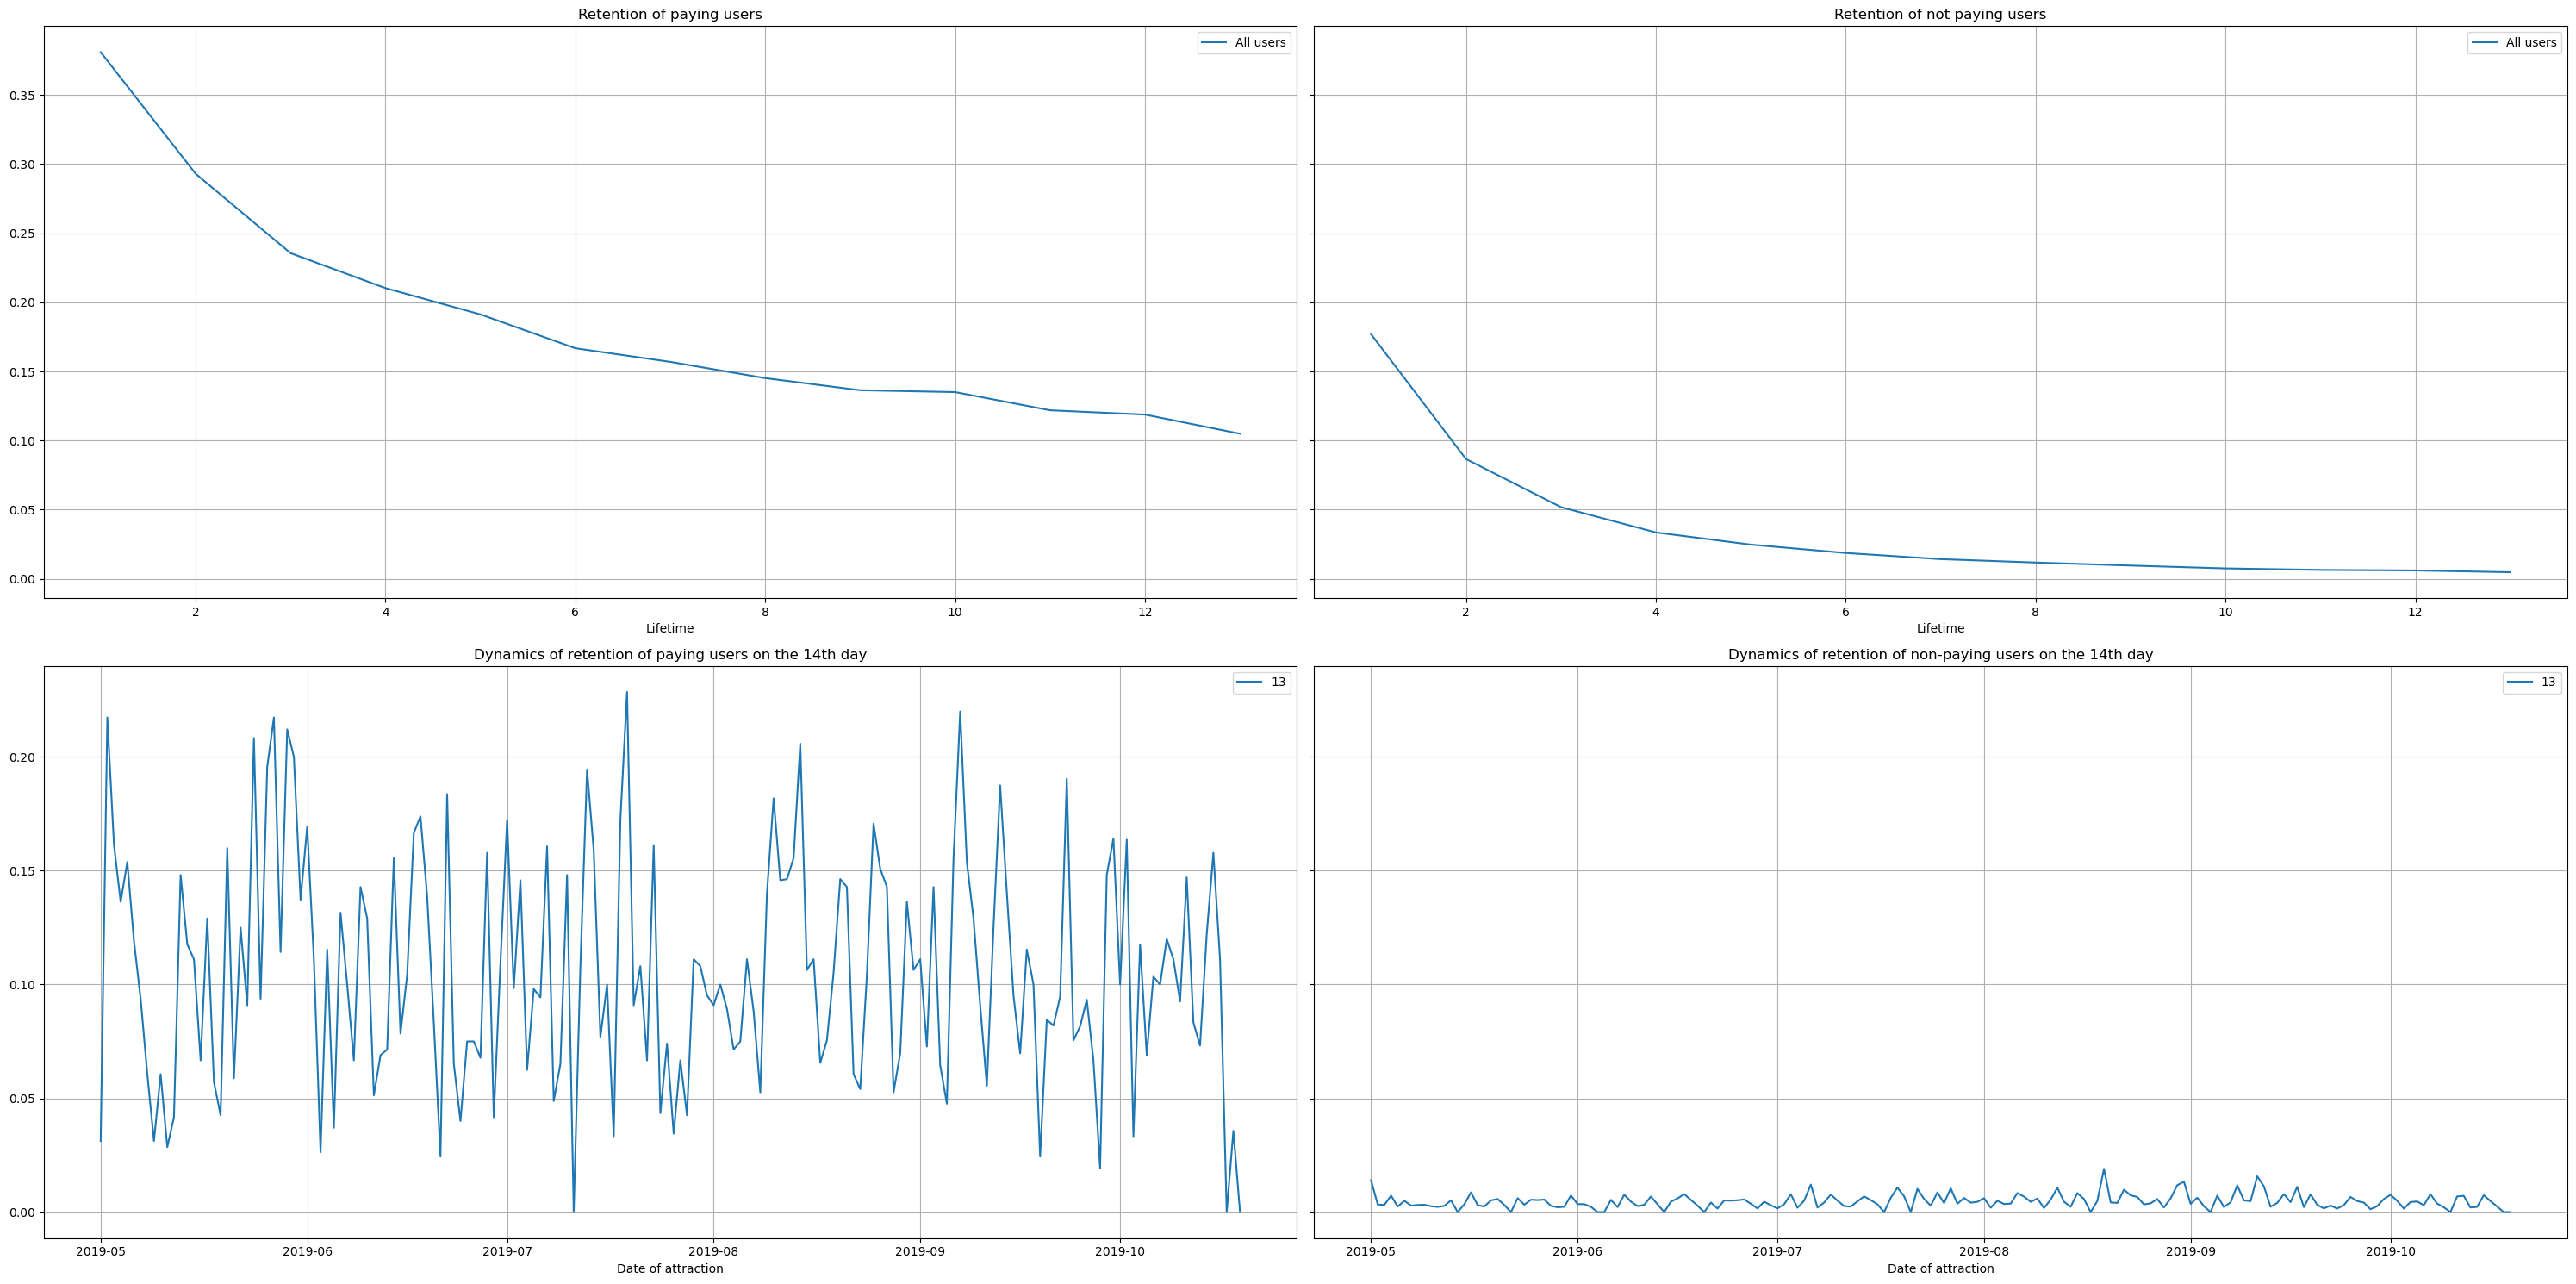

In [43]:
#excluding organic matter
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_no_orgnic, visits, observation_date, horizon_days, dimensions = [])

plot_retention(retention_grouped, retention_in_time, horizon_days)

Retention of users is difficult to call successful, the graph with dynamics shows that by the end of the period under review their number is extremely close to 0. Retention of non-paying users drops sharply by day 4, and those paying by 6.

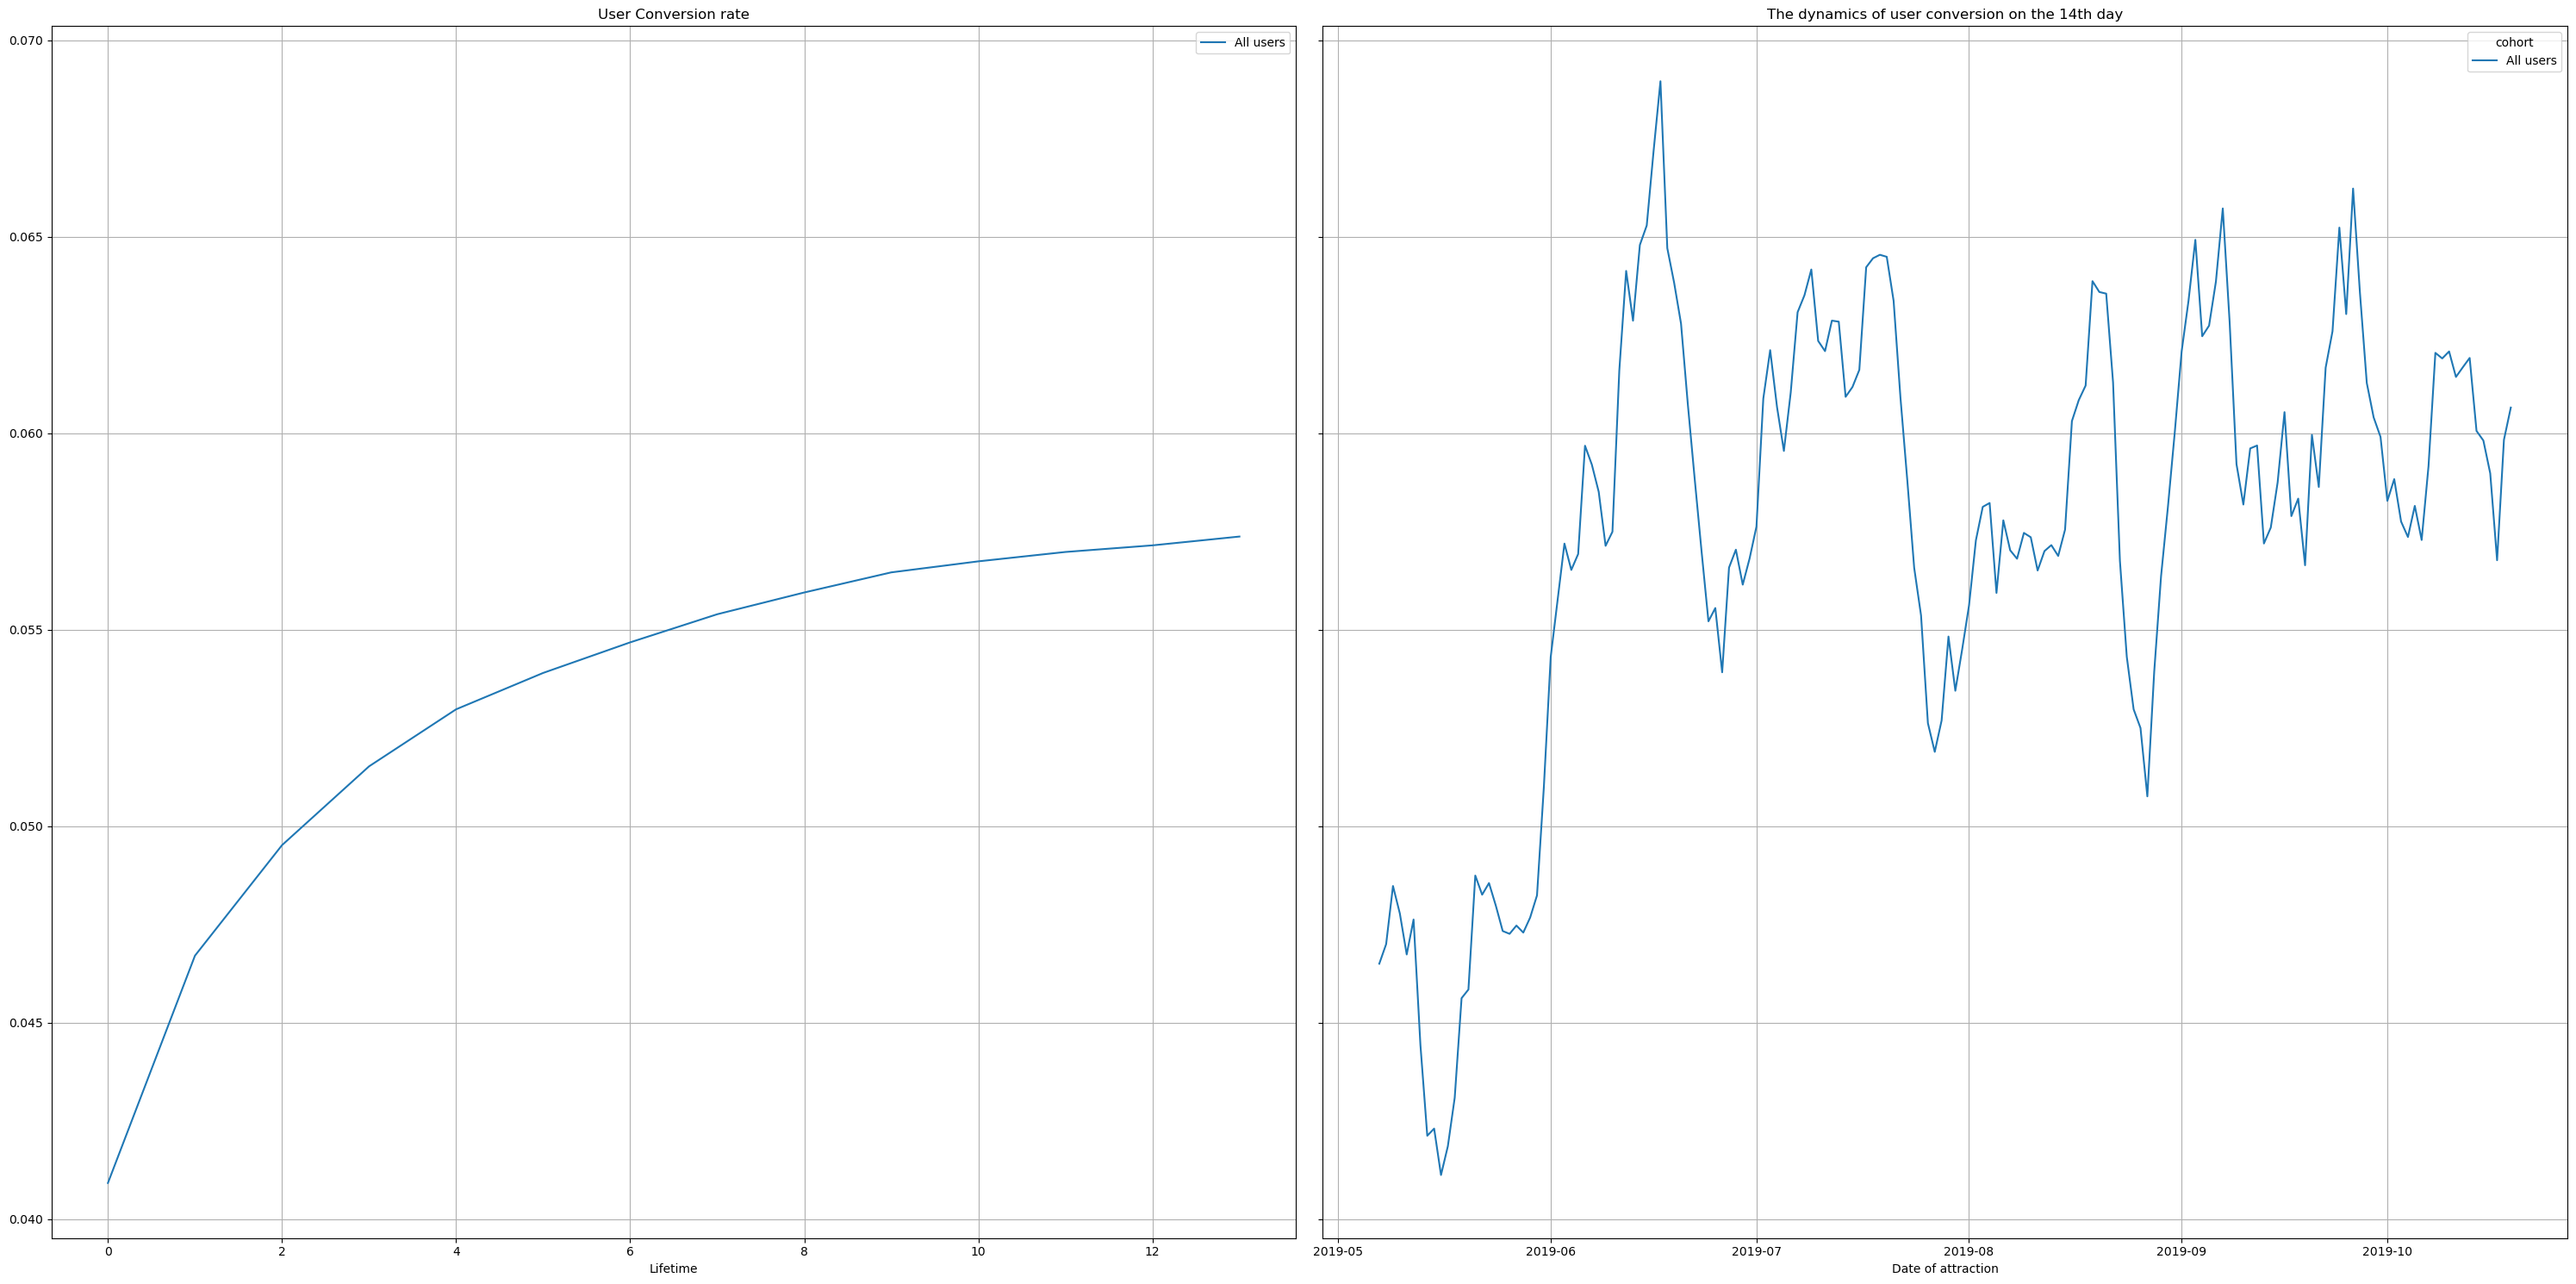

In [44]:
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_in_time, horizon_days)

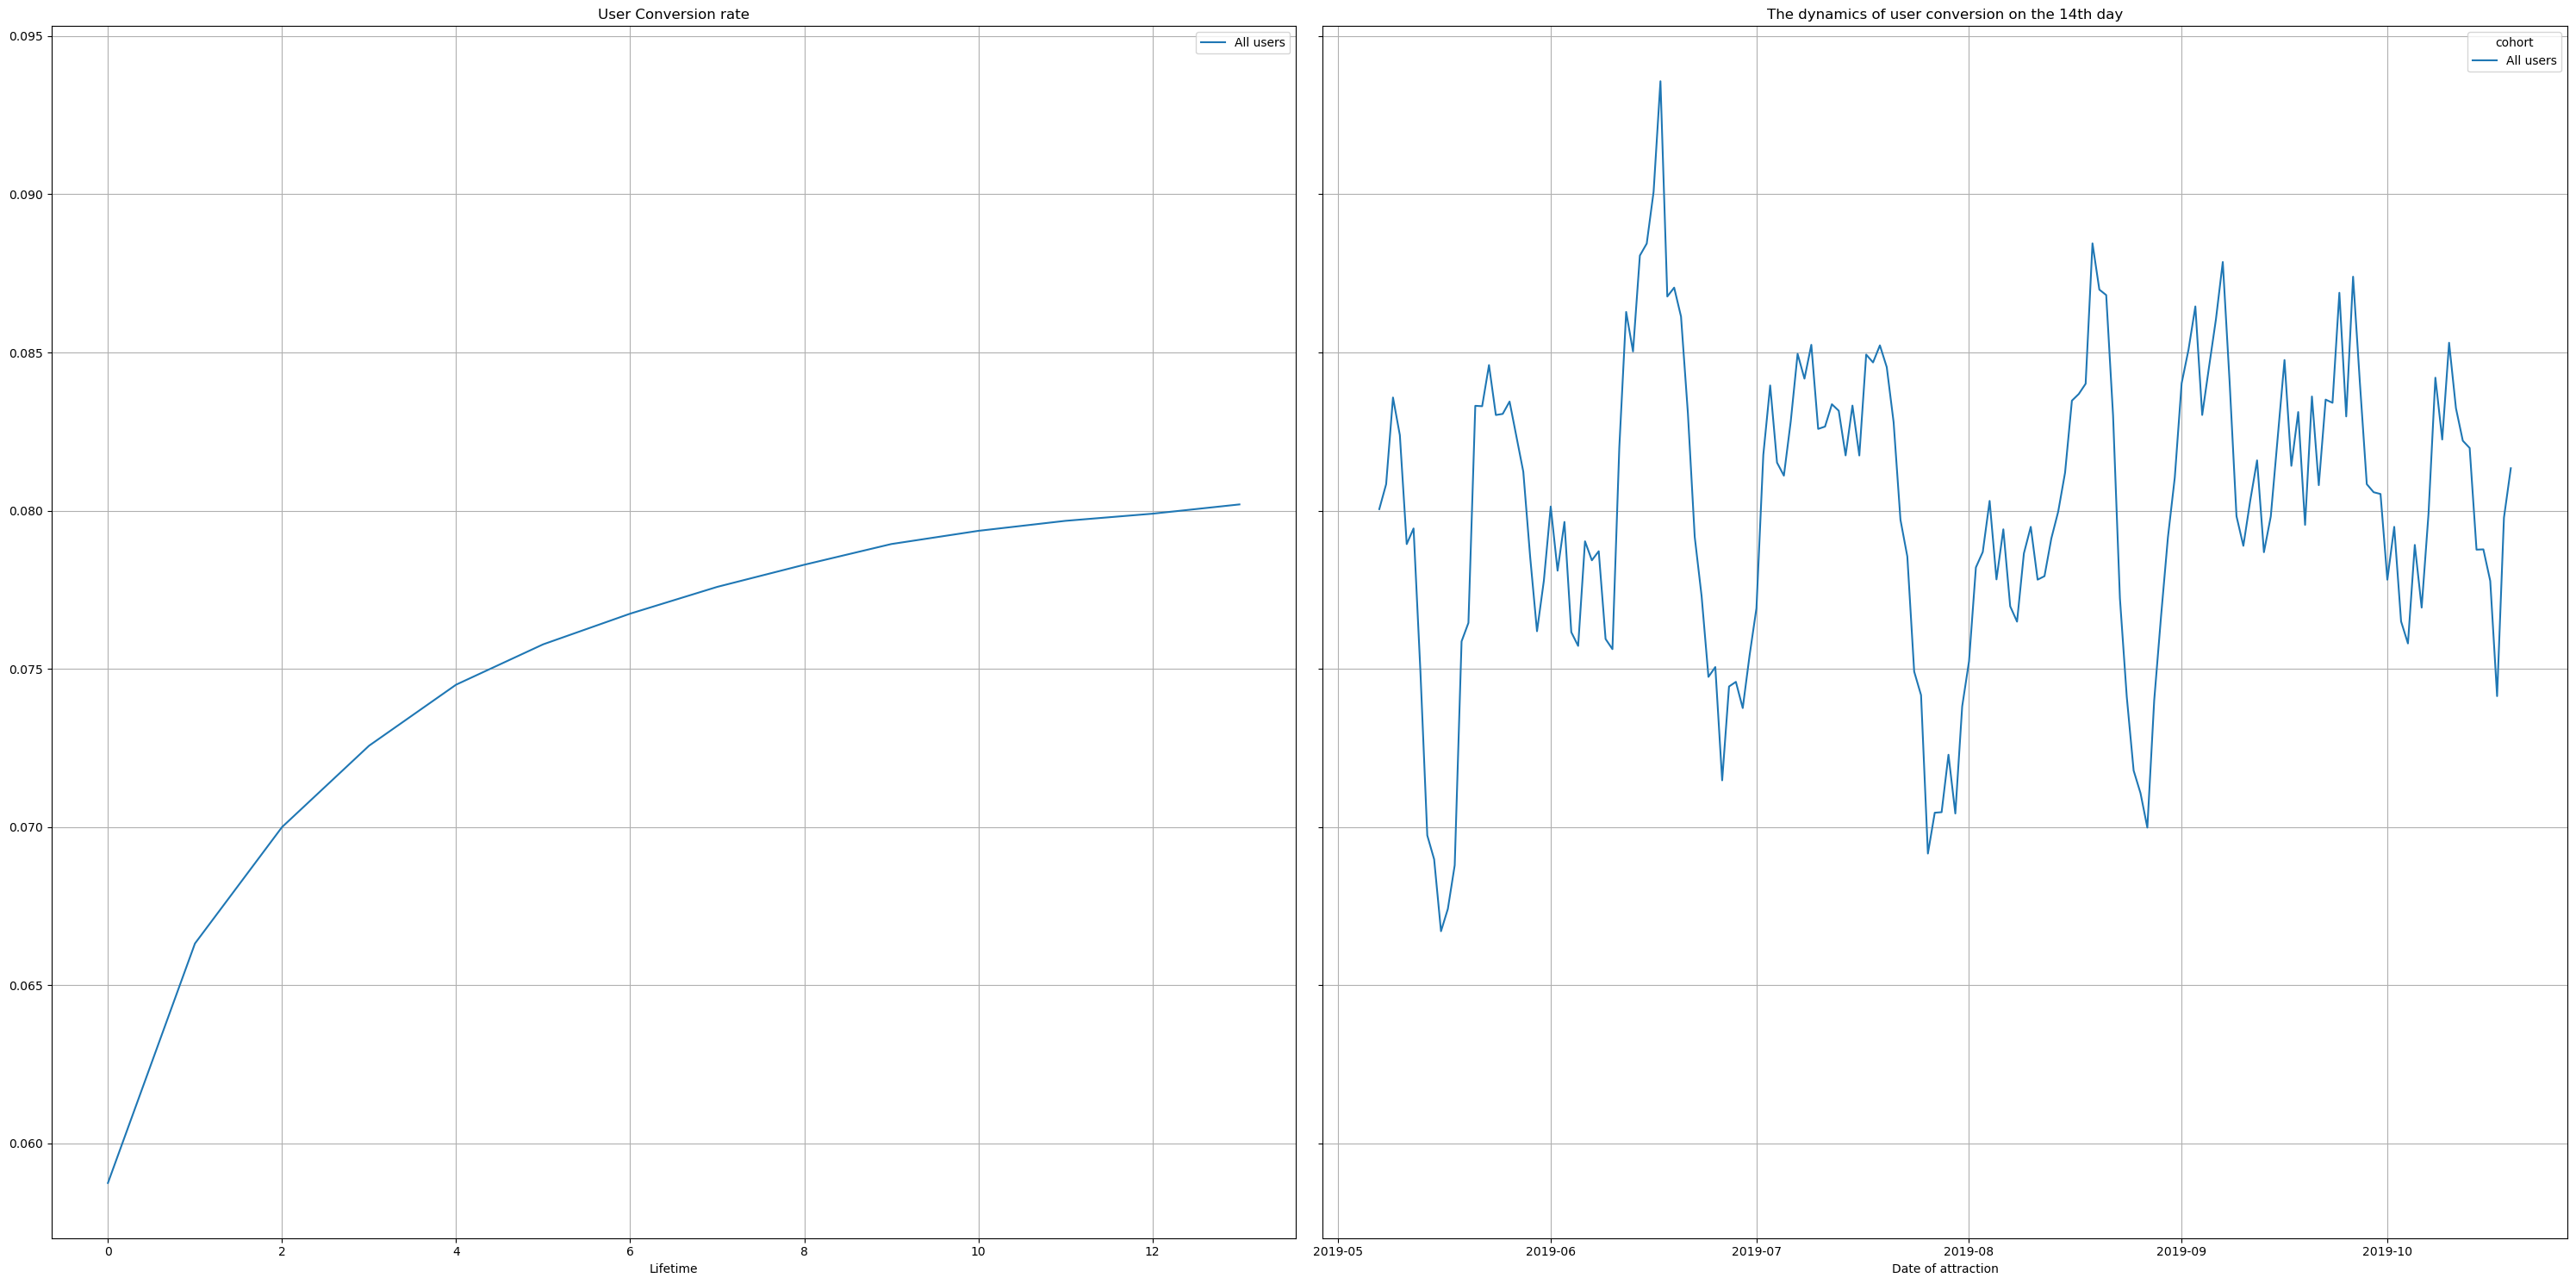

In [45]:
#excluding organic matter
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(profiles_no_orgnic, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_in_time, horizon_days)

If we look at the dynamics of conversion, we can assume that on average it has been at the same level for 14 days.

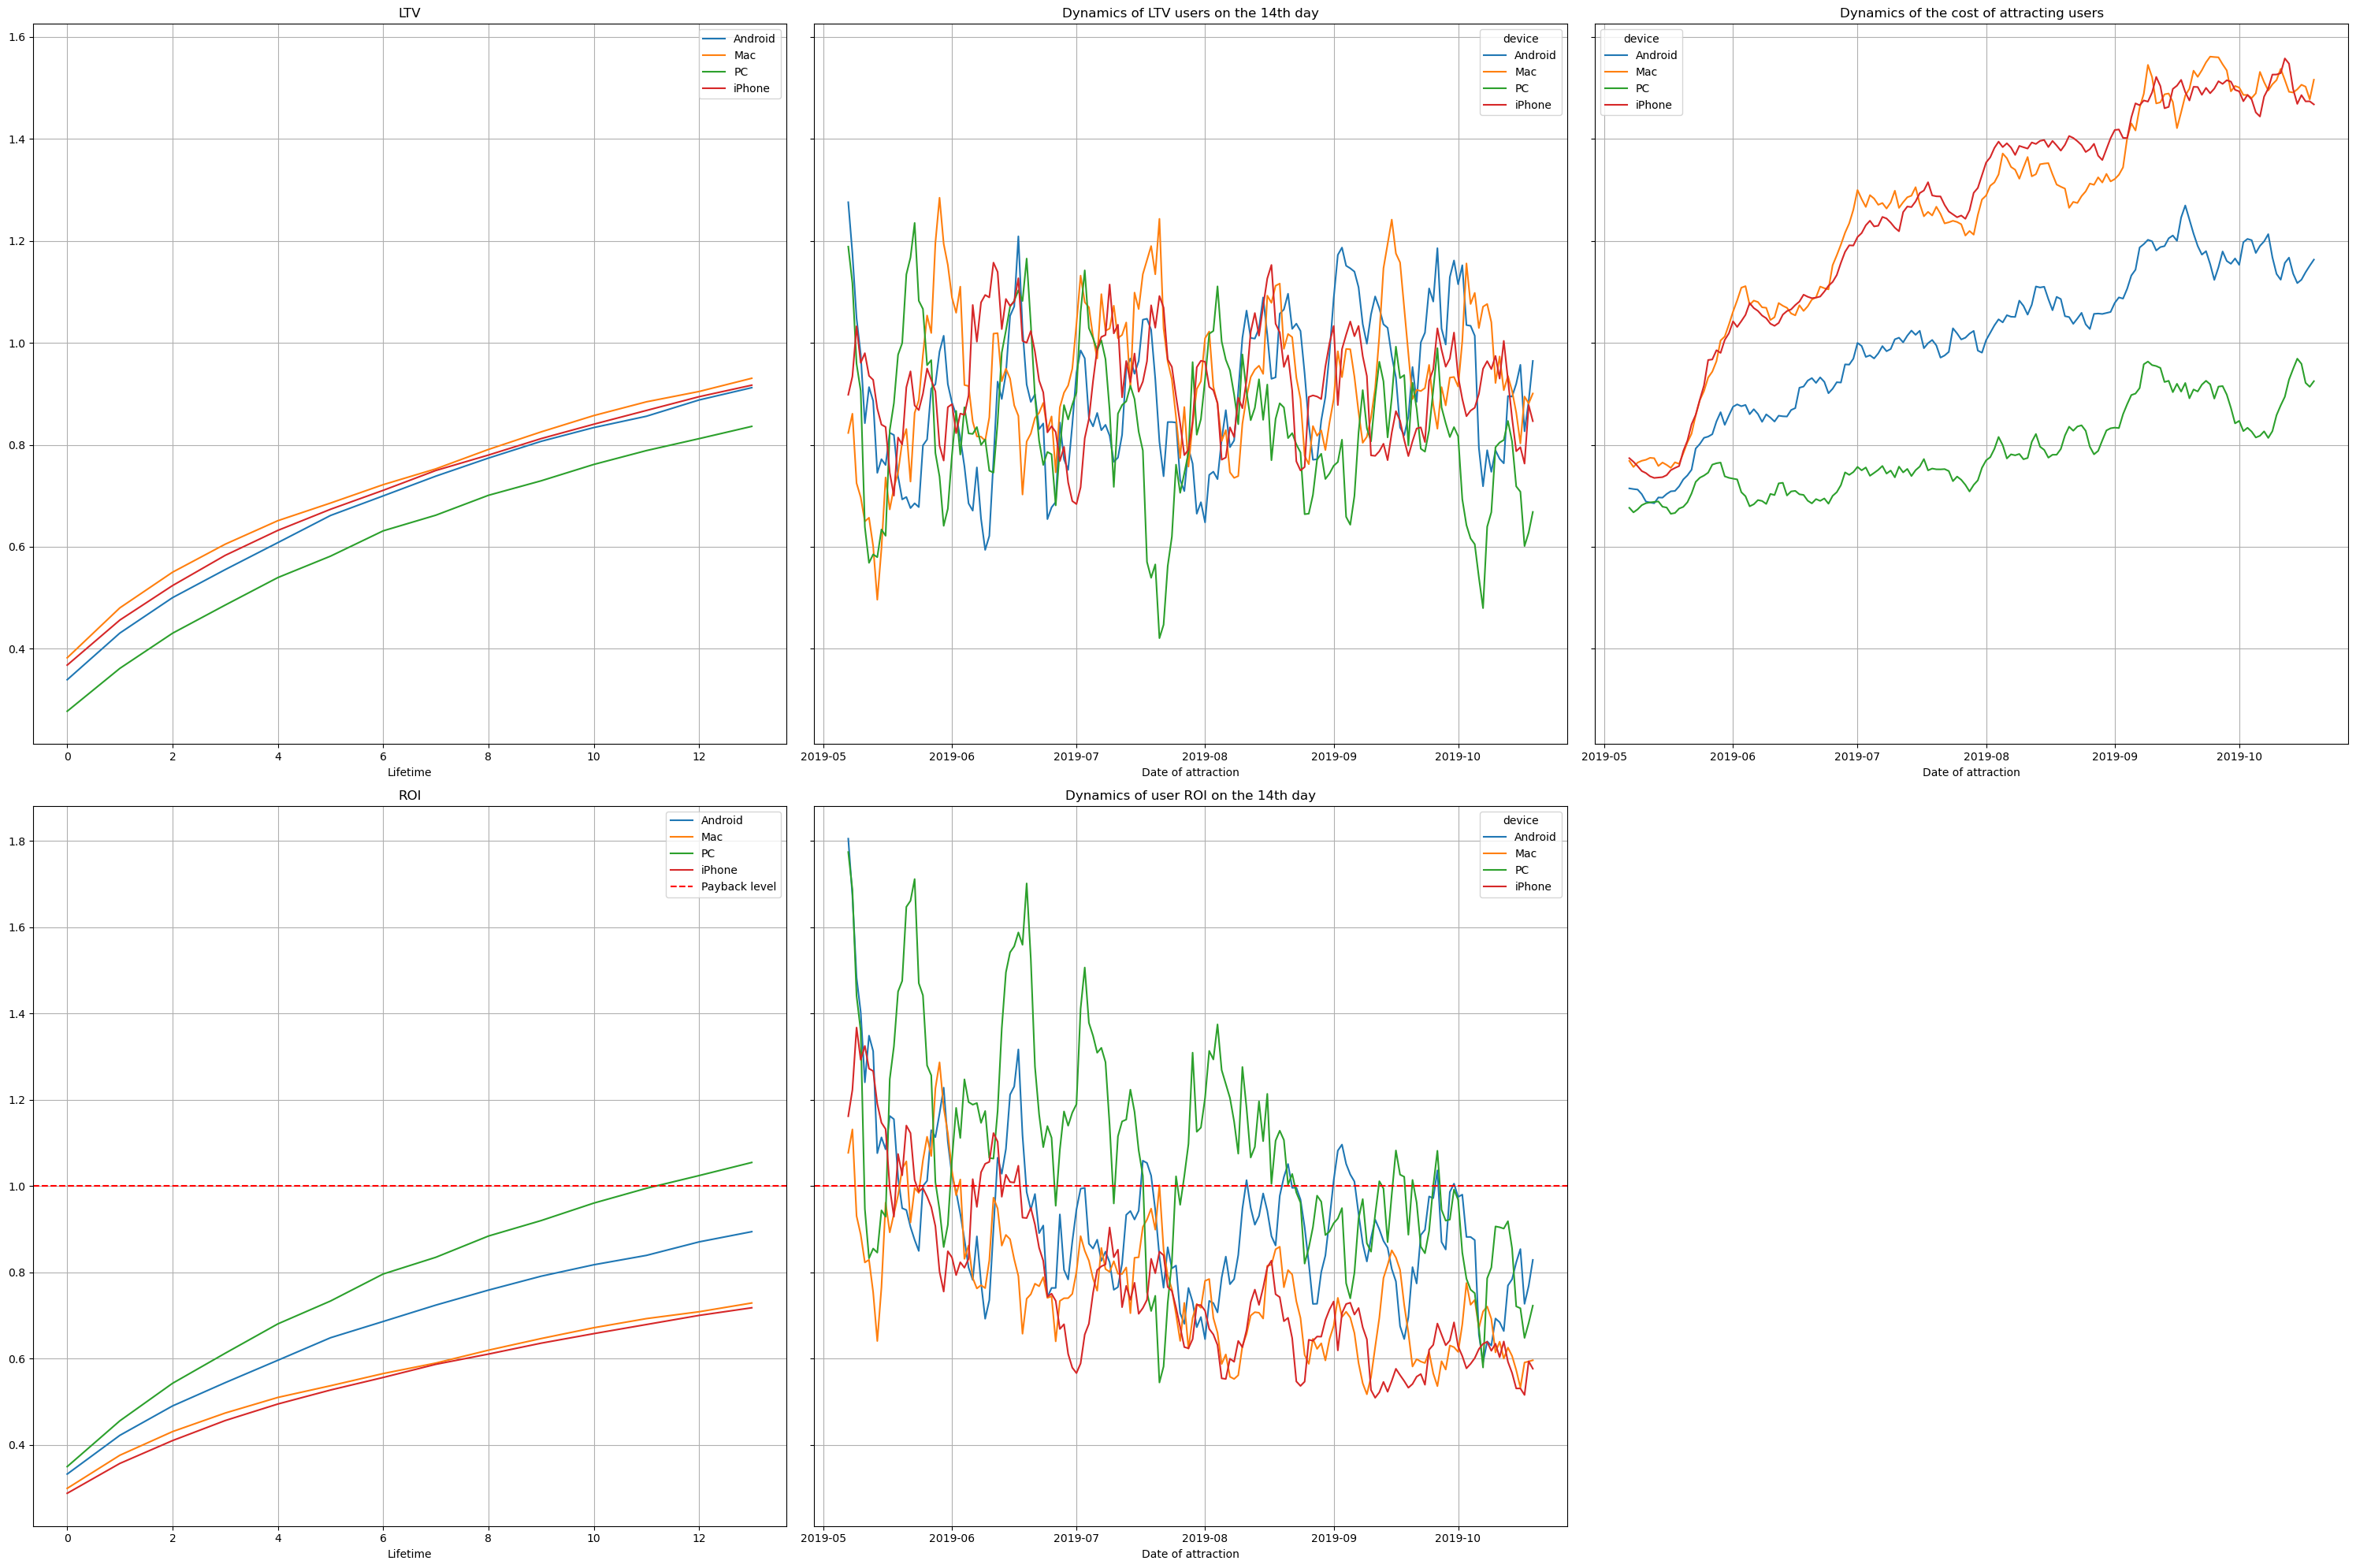

In [46]:
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(profiles_no_orgnic, orders, observation_date, horizon_days, dimensions = ['device'])

plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

Having analyzed the graphs above, the PC demonstrates the best indicator of the devices. Advertising costs for PCs are not growing as actively as for other devices, most likely this factor affects the fact that only for PCs the ROI has exceeded the payback level since time. LTV is the lowest for PC users, and in dynamics, it is the PC graph that sags the lowest.

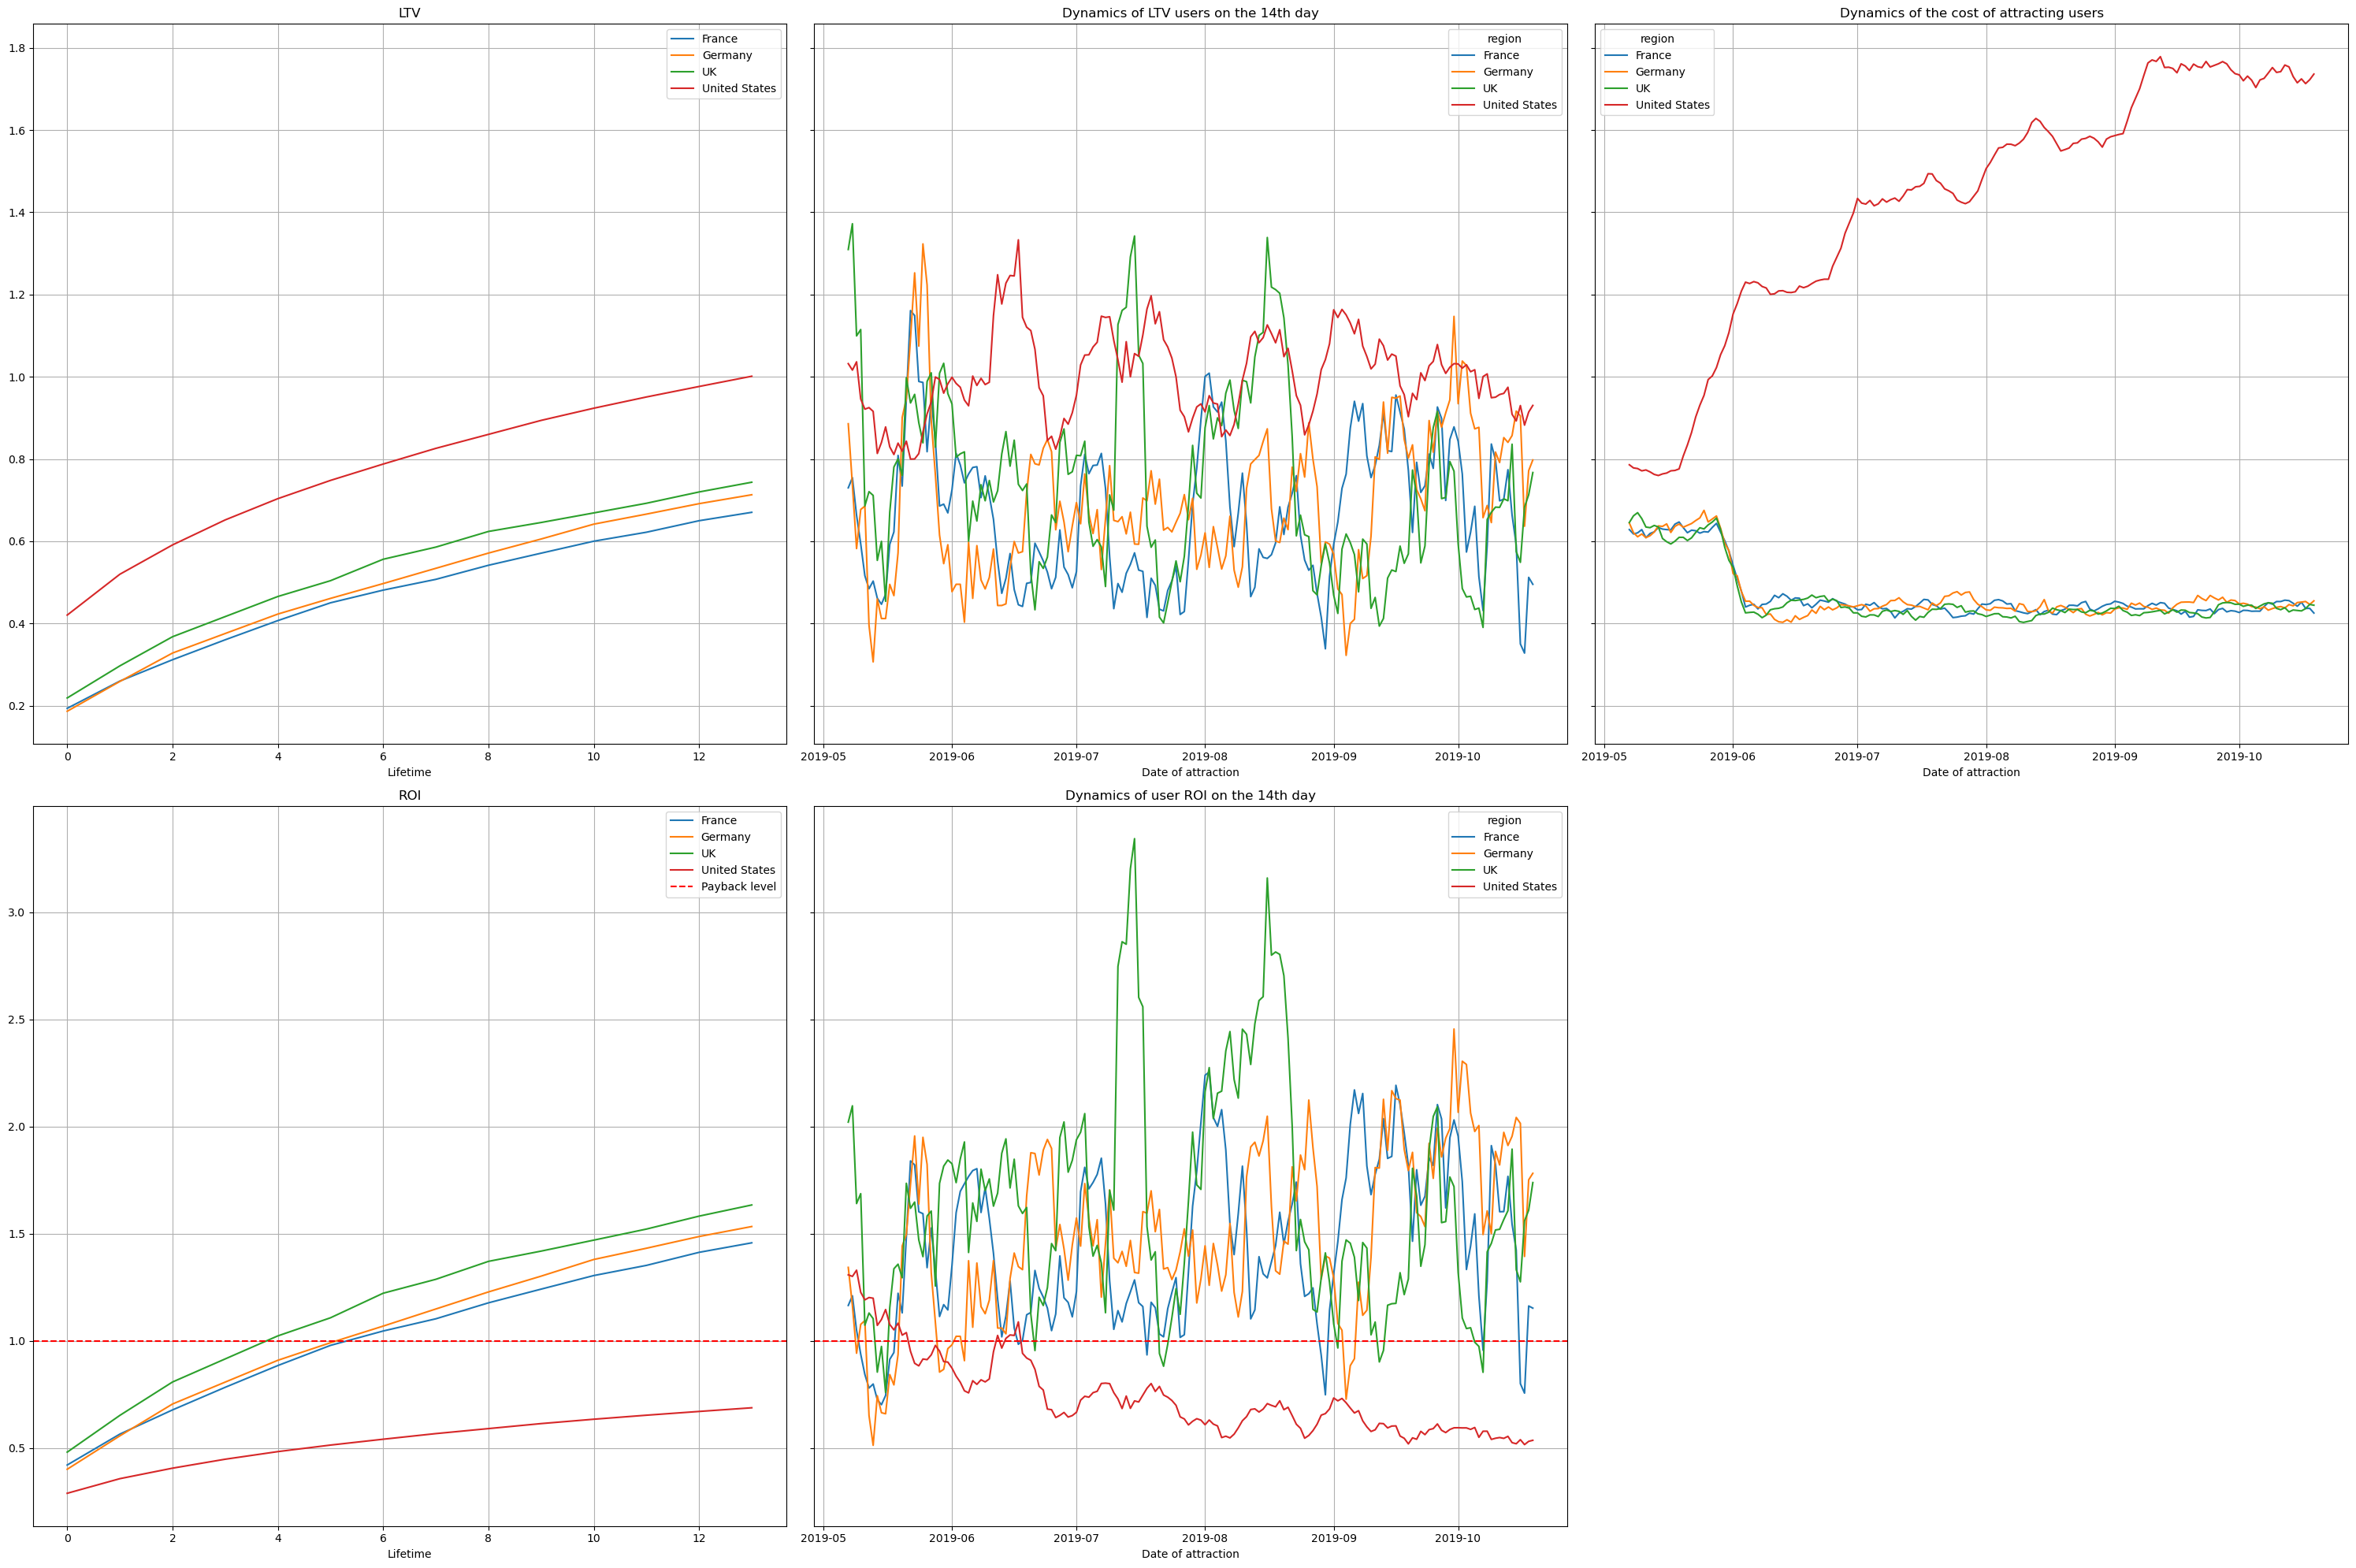

In [47]:
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(profiles_no_orgnic, orders, observation_date, horizon_days, dimensions = ['region'])

plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, horizon_days, window=7)

From the graphs, we can conclude that despite the fact that the lifetime value of customers in the United States is higher than in other regions, the cost of attracting customers to the United States is several times higher than in other regions and as a result it simply does not pay off. This is evidenced by the chart of ROI dynamics on the 14th day, it is in the United States that it falls below the payback level. For the rest of the regions, the indicators are approximately equal, and the dynamics of the cost of attracting them is quite low, and at the same time their payback is growing.

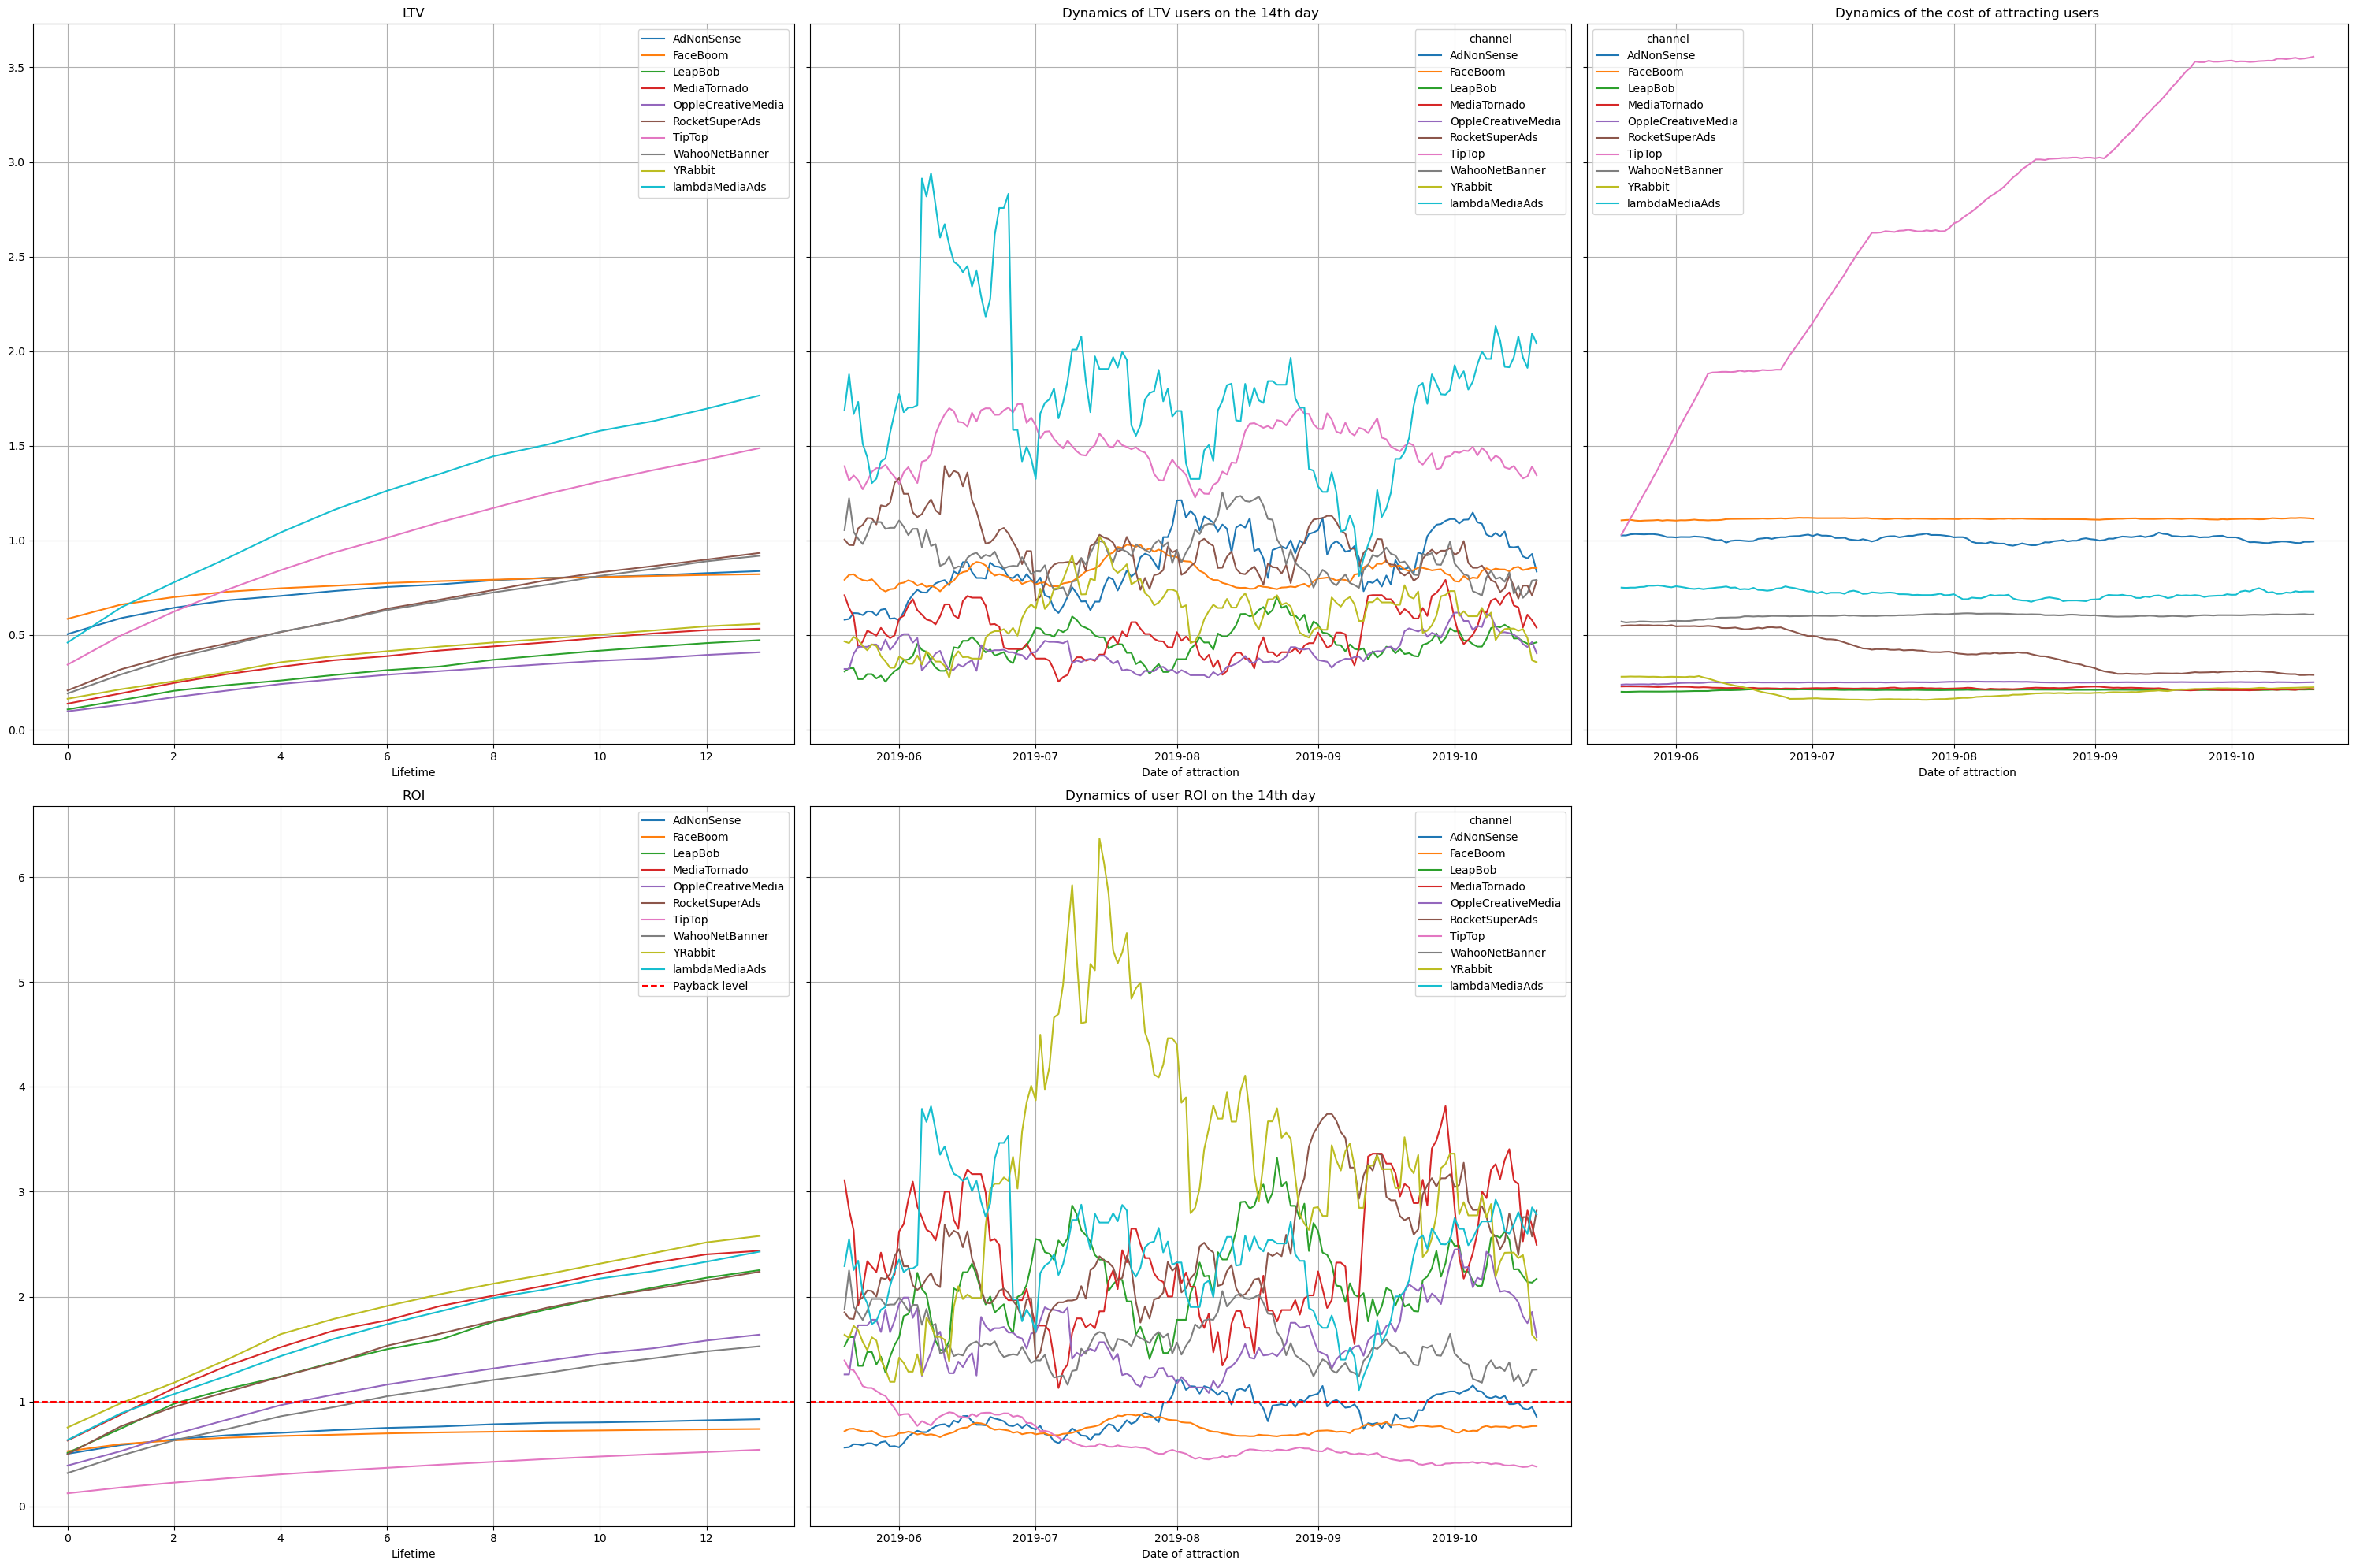

In [48]:
result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time = get_ltv(profiles_no_orgnic, orders, observation_date, horizon_days, dimensions = ['channel'])

plot_ltv_roi(result_grouped, result_in_time, roi_grouped, roi_in_time, horizon_days, window=20)


As for the payback of advertising through channels, despite the success of attracting users with TipTop, AdNonSense and FaceBoom channels, which was demonstrated earlier, they do not show positive payback results, and TipTop costs are also extremely high. But lambdaMediaAds and TipTop show the best results in terms of customer value. And lambda Media Ads is also the best at showing itself in the dynamics of lifetime value.

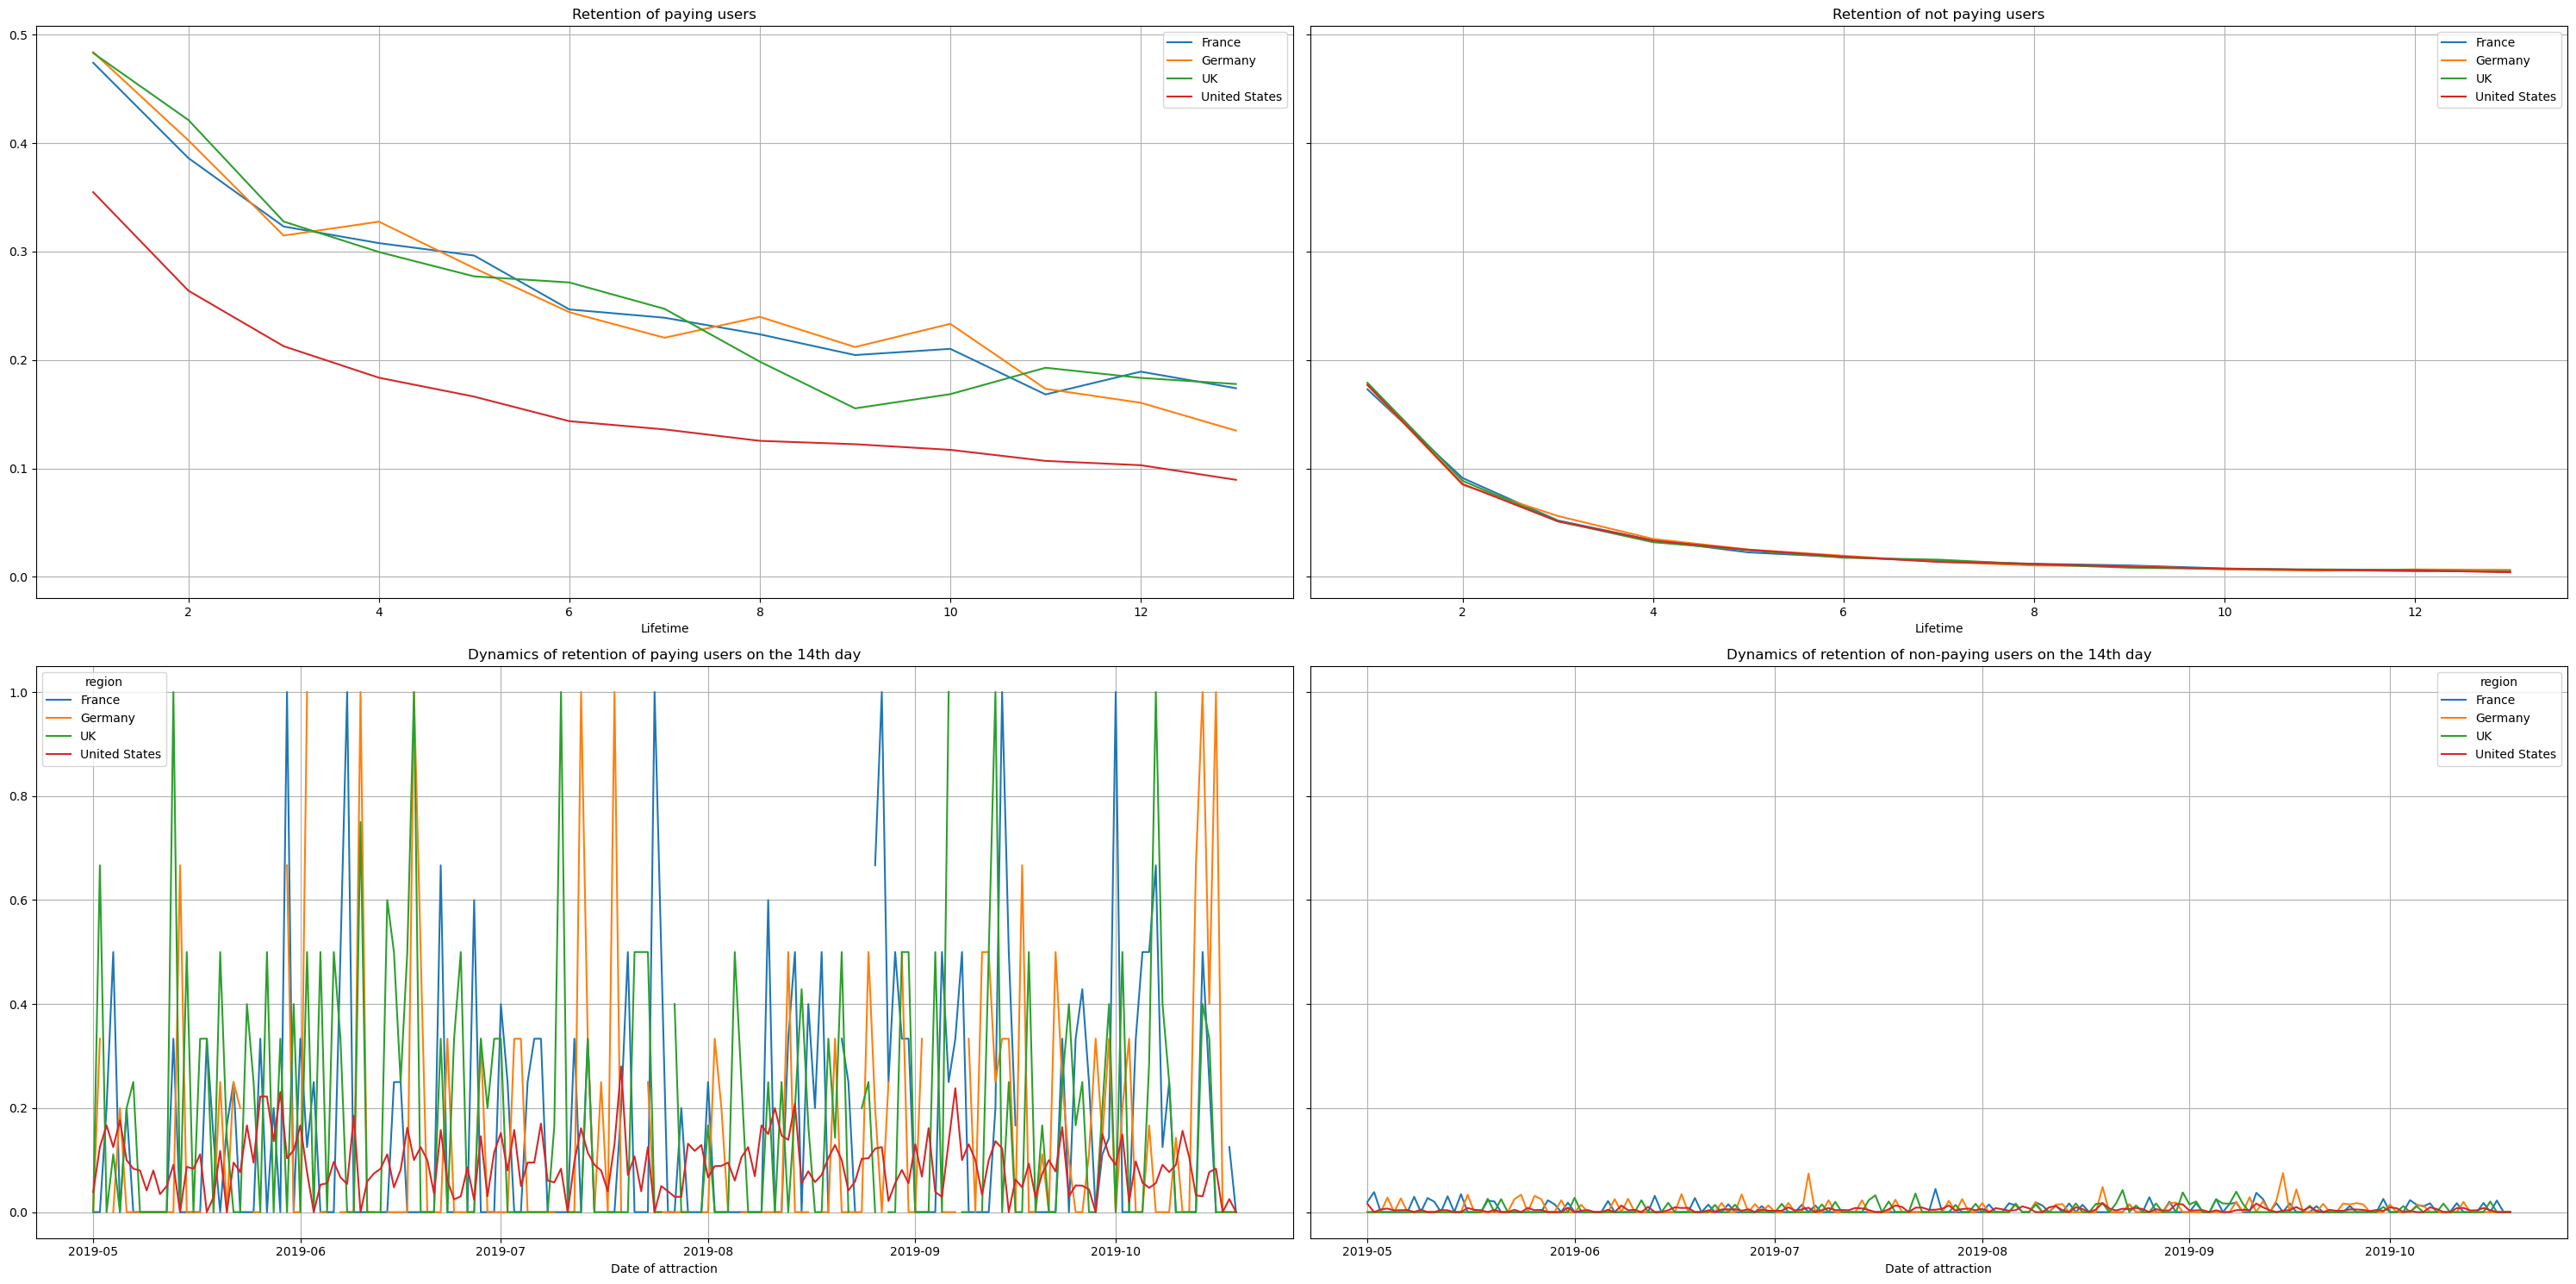

In [49]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_no_orgnic, visits, observation_date, horizon_days, dimensions = ['region'])

plot_retention(retention_grouped, retention_in_time, horizon_days)

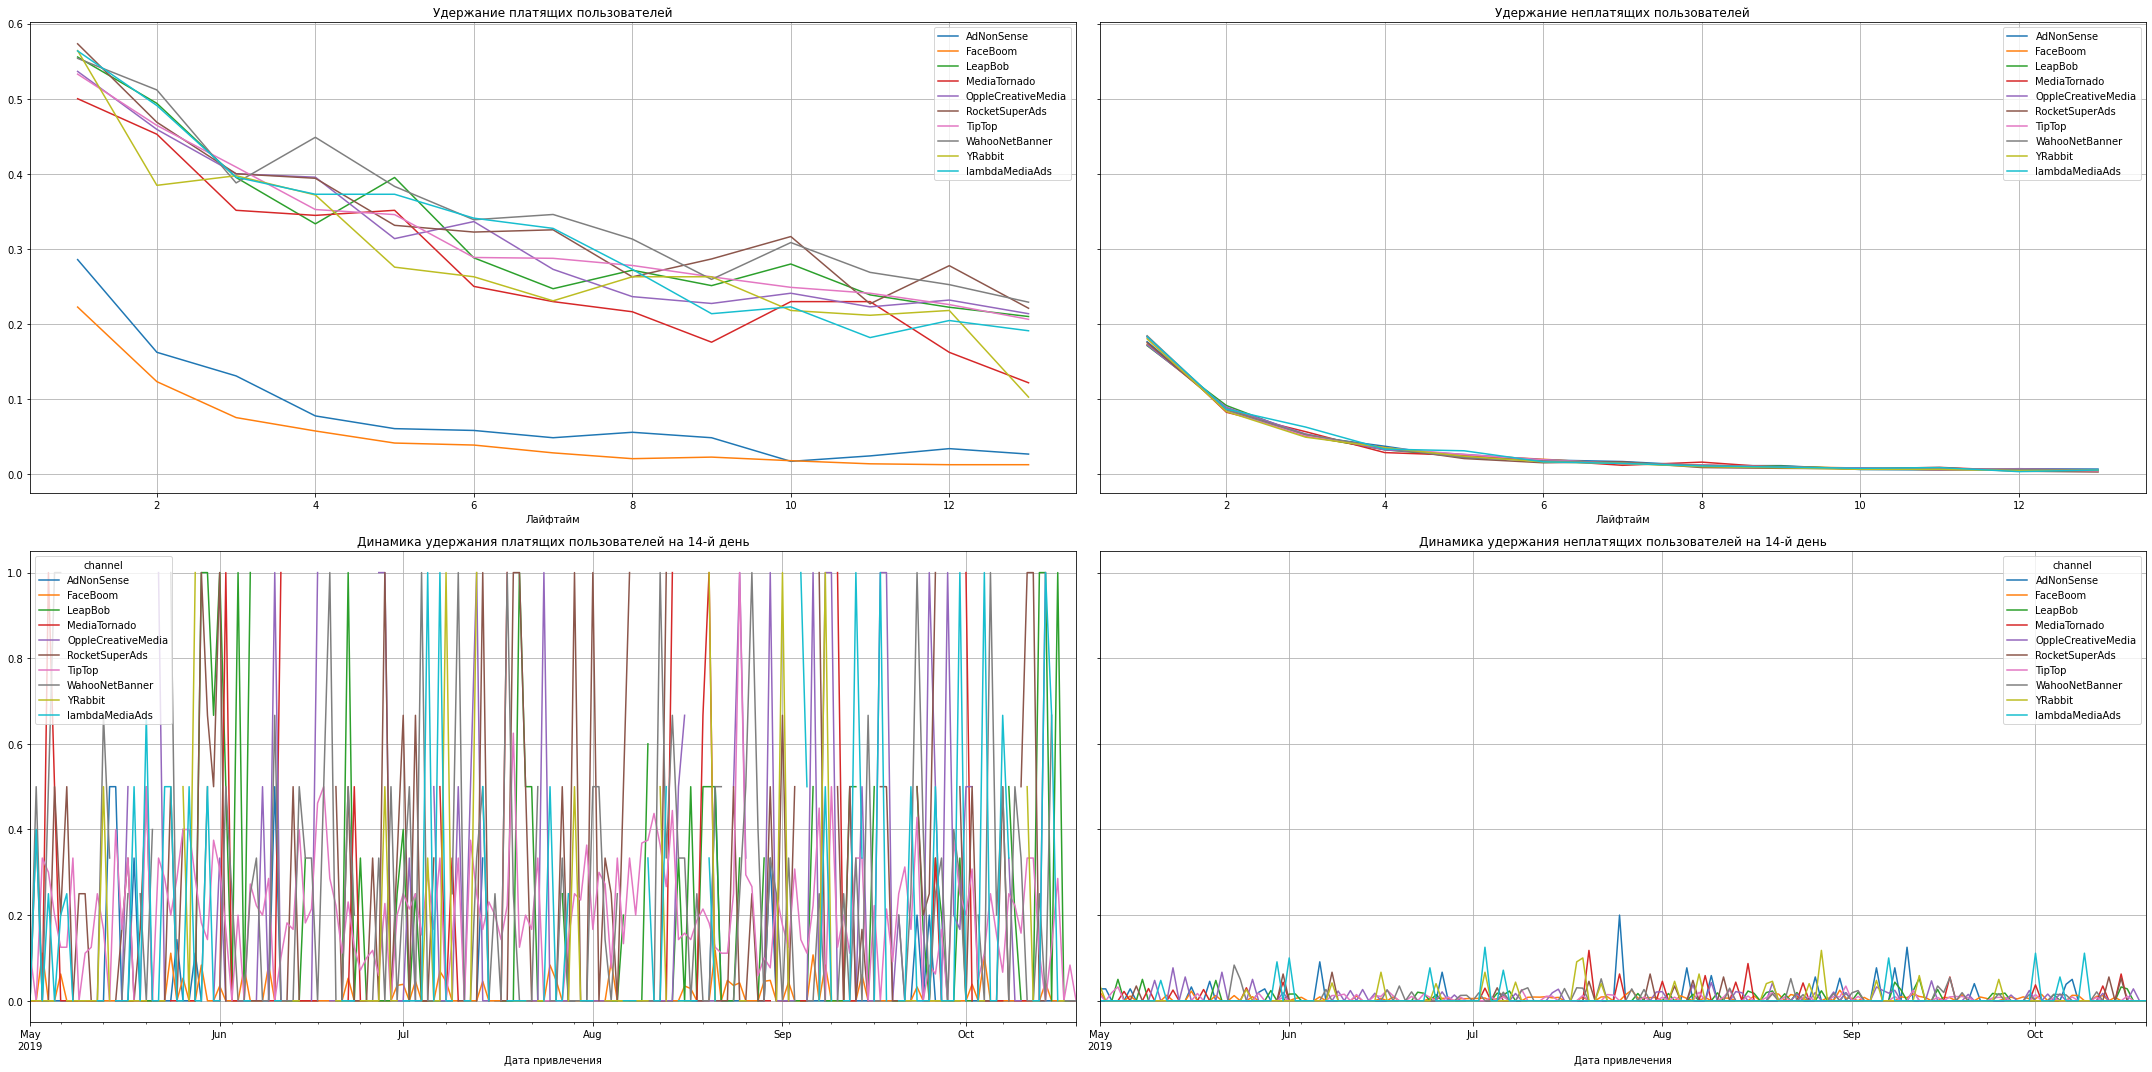

In [46]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_no_orgnic, visits, observation_date, horizon_days, dimensions = ['channel'])

plot_retention(retention_grouped, retention_in_time, horizon_days)


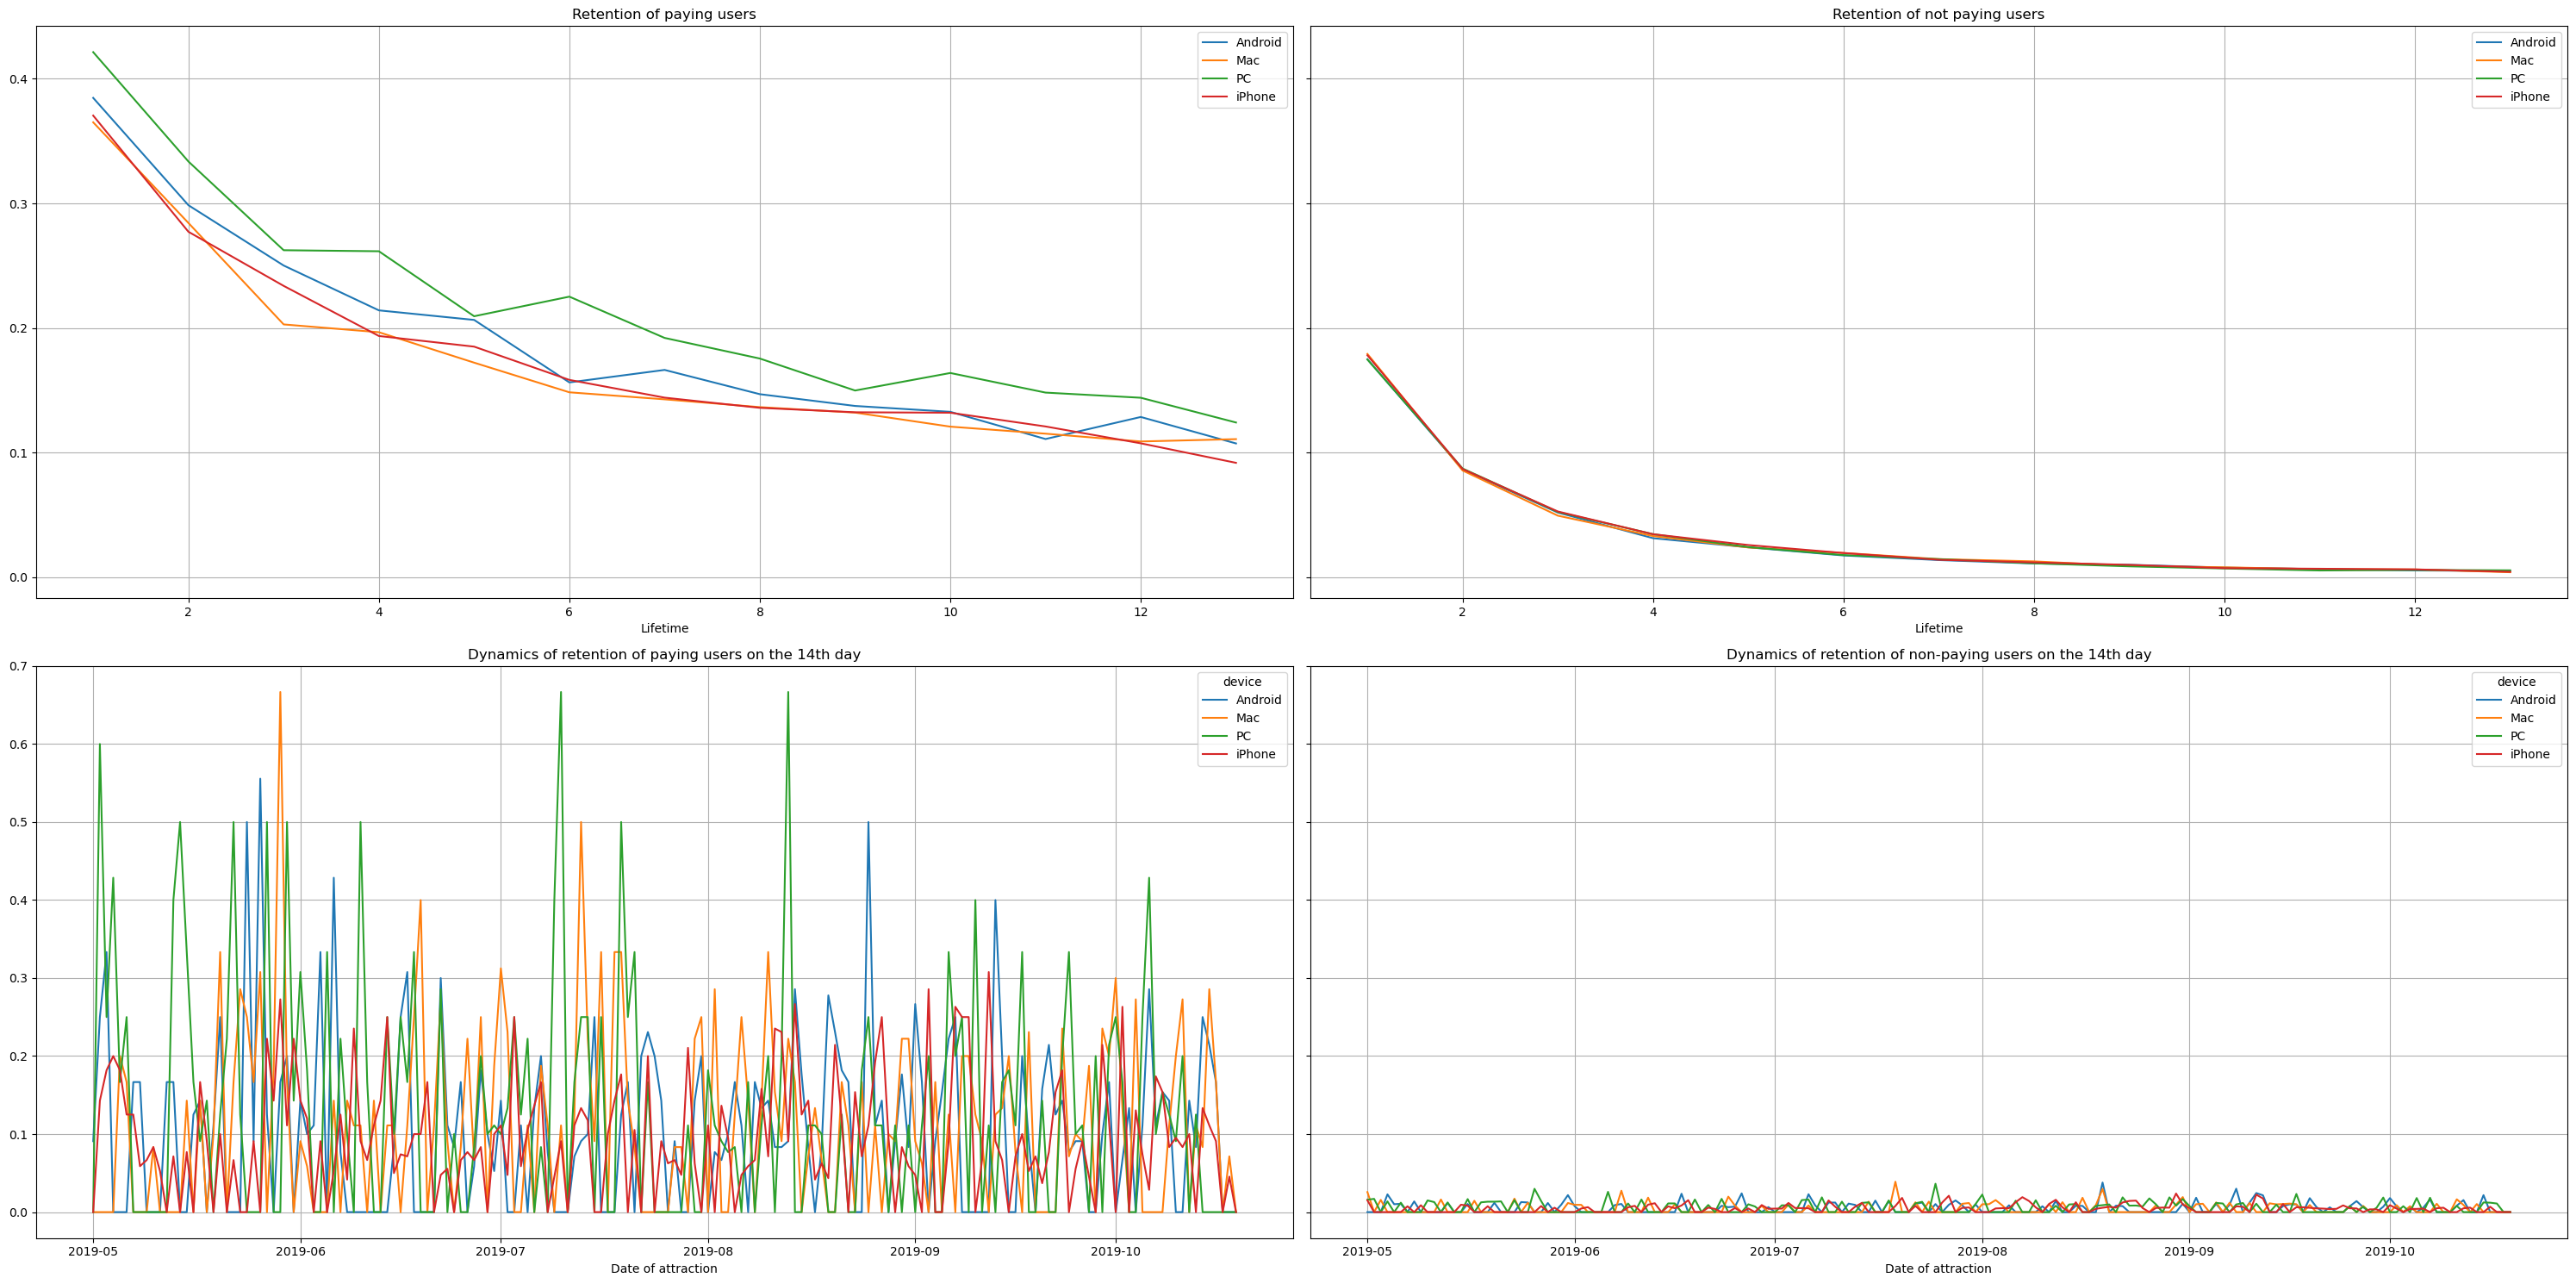

In [50]:
retention_raw, retention_grouped, retention_in_time = get_retention(profiles_no_orgnic, visits, observation_date, horizon_days, dimensions = ['device'])

plot_retention(retention_grouped, retention_in_time, horizon_days)


Retention of paying users suffers a lot in the USA, it is at the lowest level, and for non-paying users it is approximately equal in terms of regions and drops sharply by day 4. But if we consider the dynamics of attracting paying users, then for the United States it is the most stable, although extremely low.
FaceBoom and AdNonSense show the worst results in retaining non-paying users.
The best way to retain paying users is among those who prefer a PC to use the application, for non-paying users, they are on the same level.

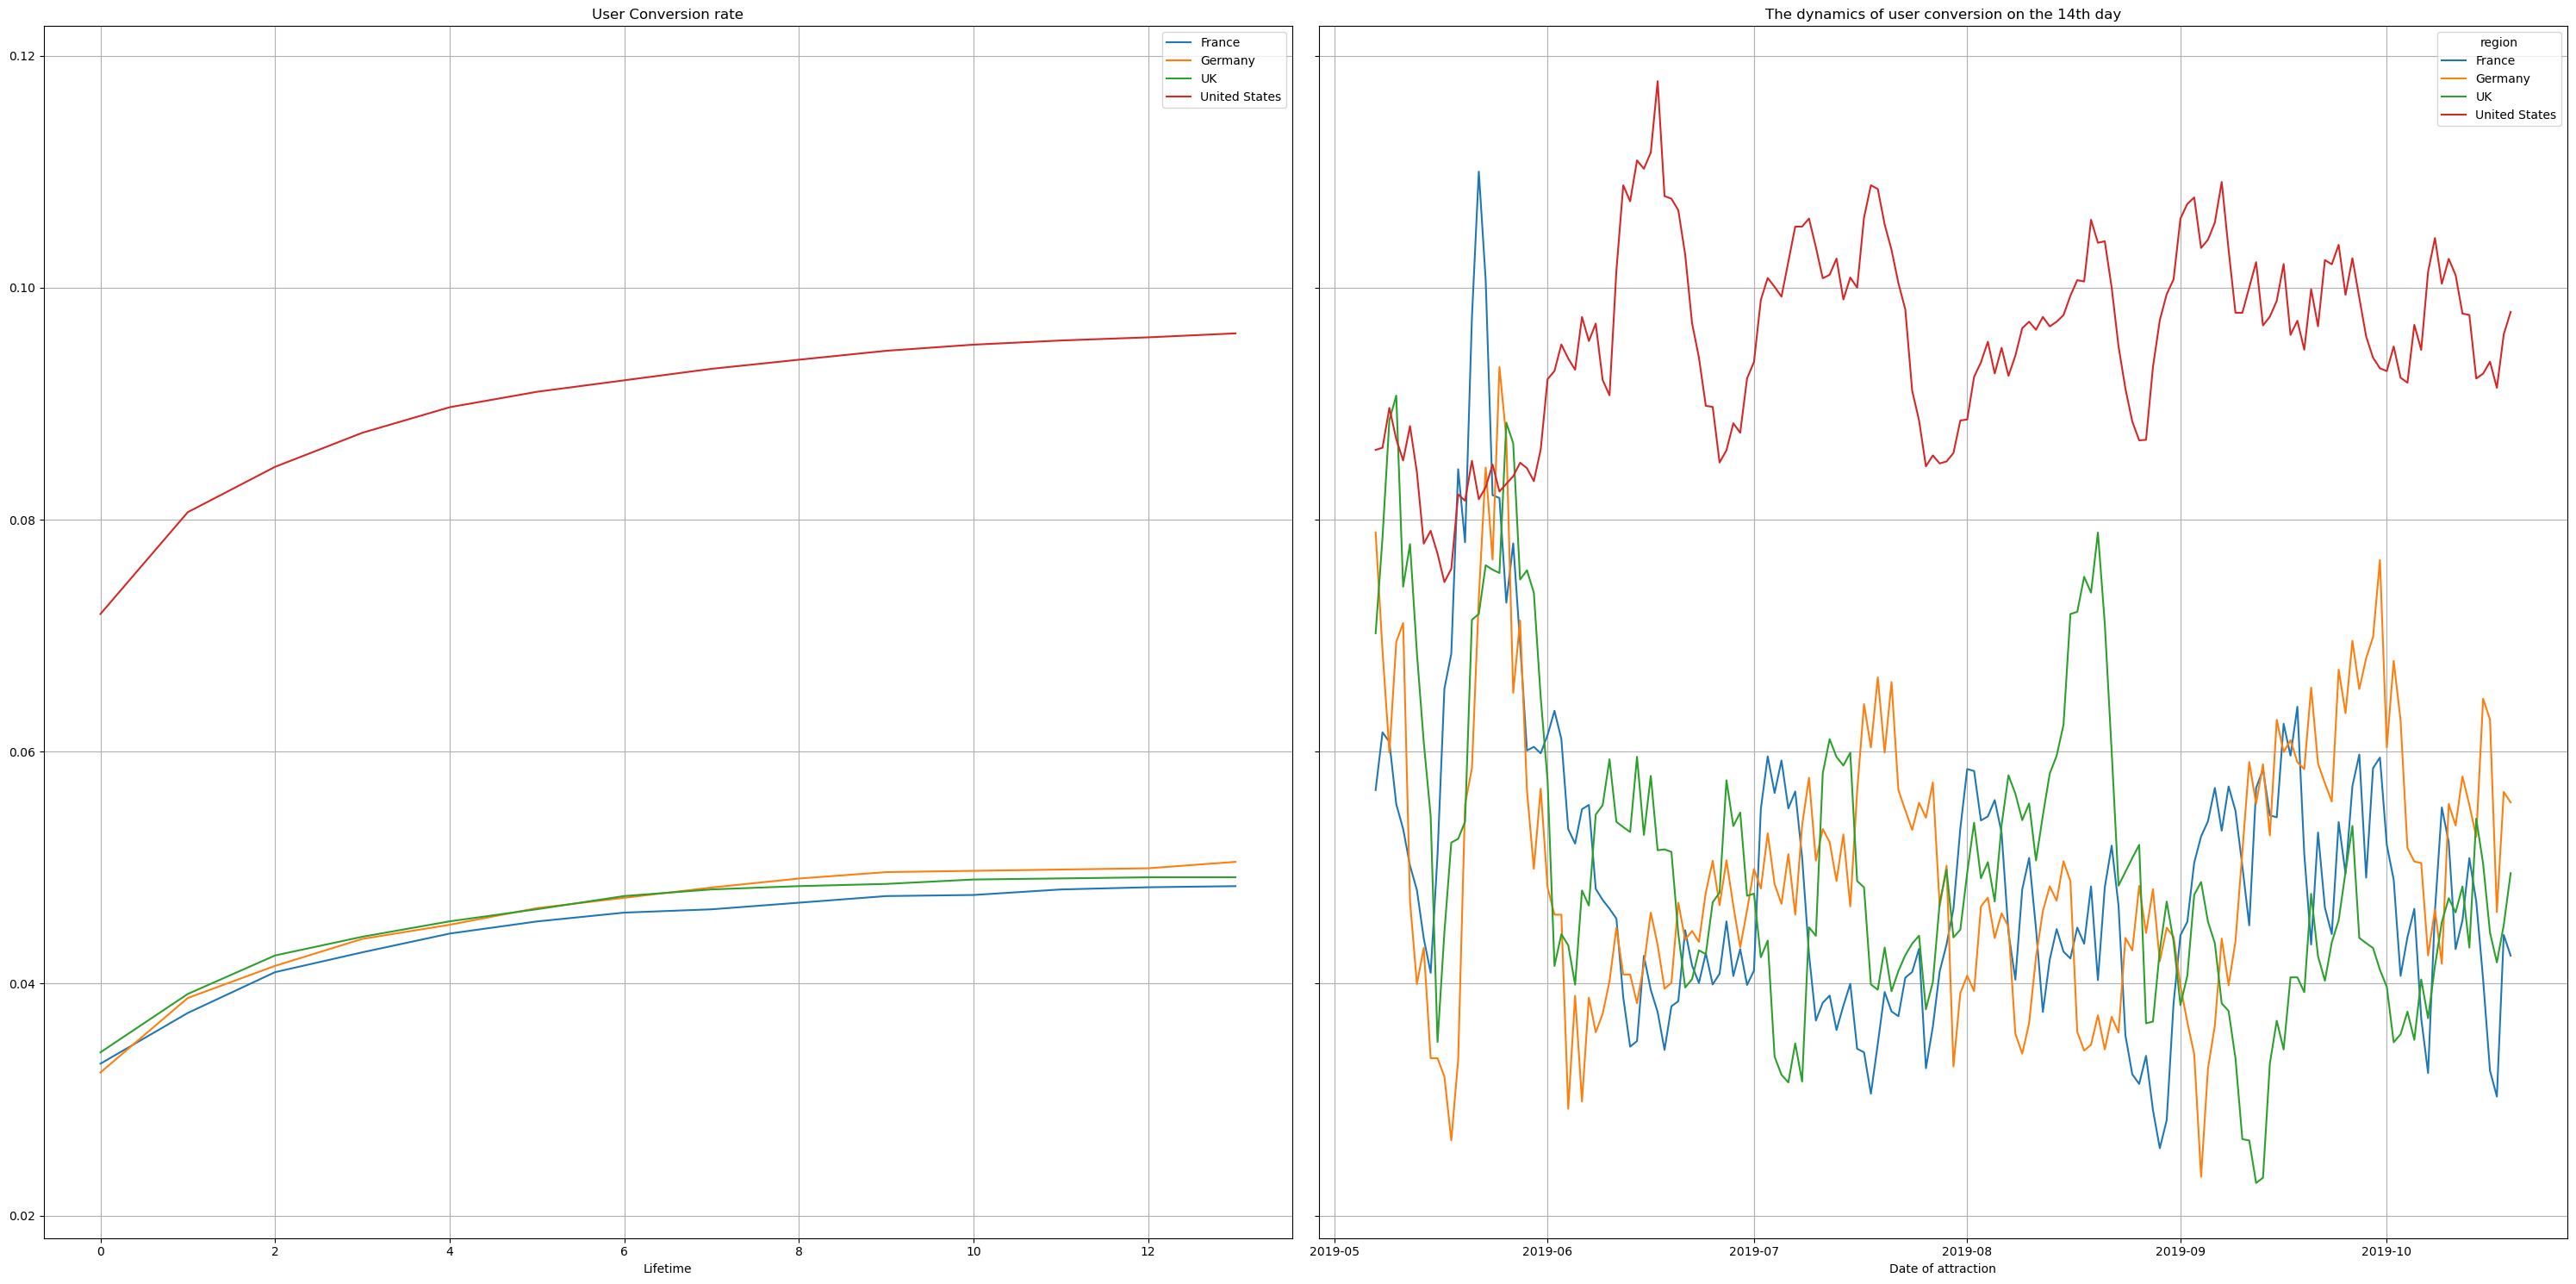

In [51]:
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(profiles_no_orgnic, orders, observation_date, horizon_days, dimensions = ['region'])

plot_conversion(conversion_grouped, conversion_in_time, horizon_days)

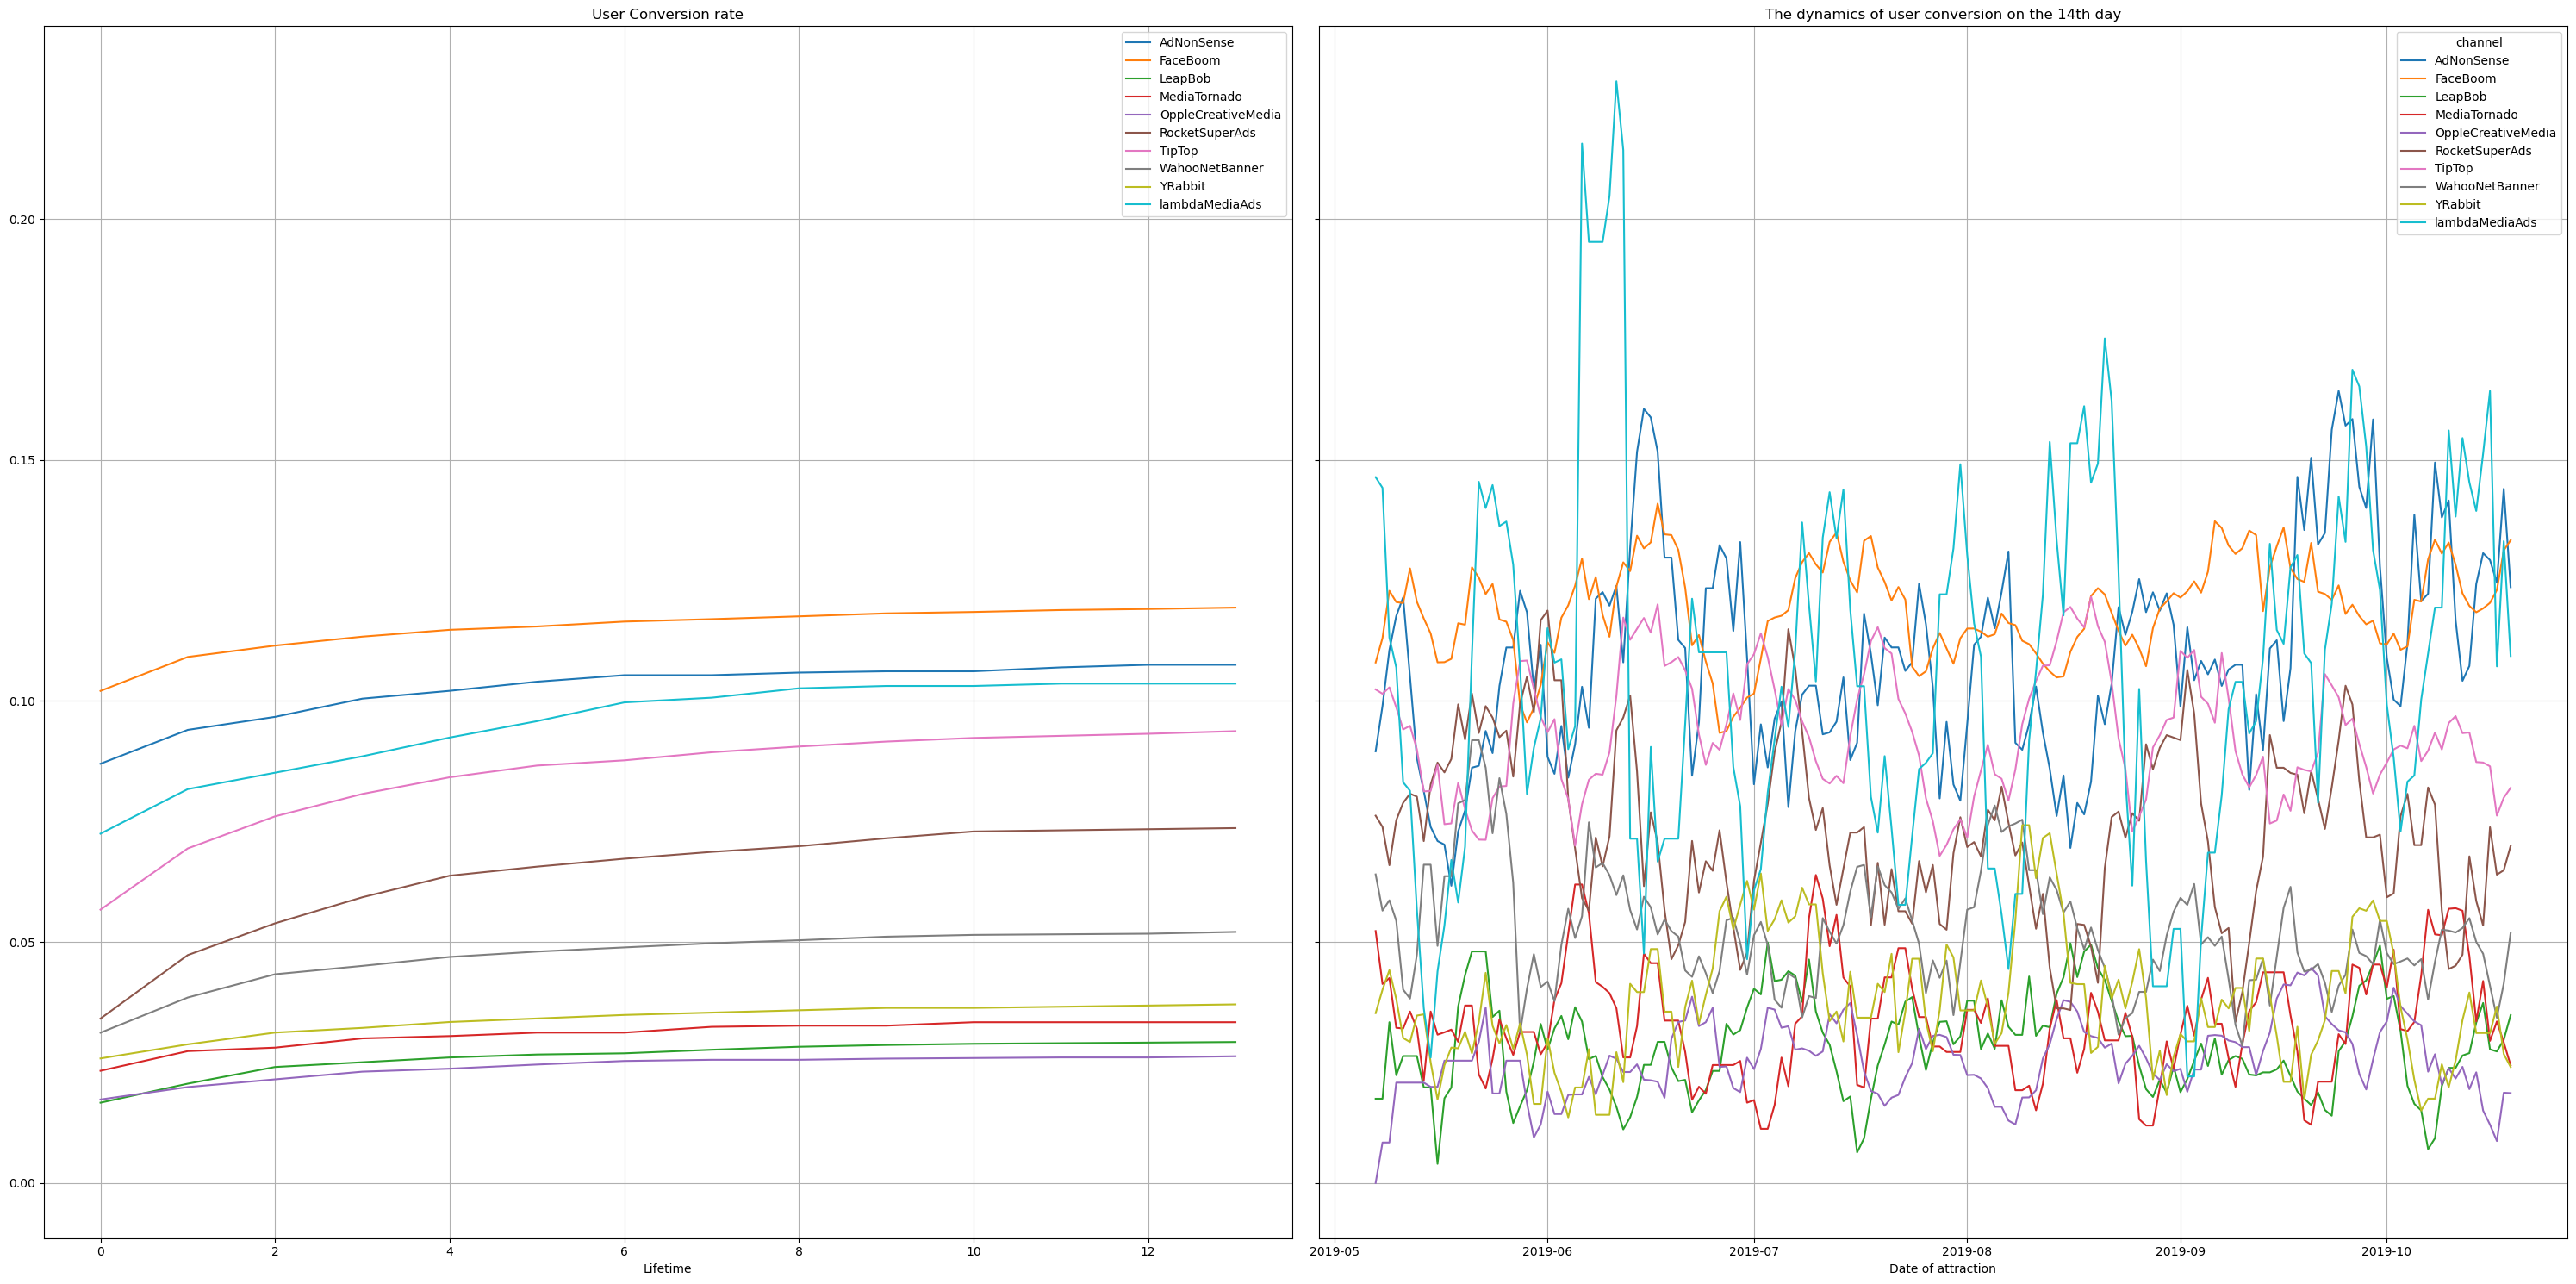

In [52]:
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(profiles_no_orgnic, orders, observation_date, horizon_days,dimensions = ['channel'])

plot_conversion(conversion_grouped, conversion_in_time, horizon_days)

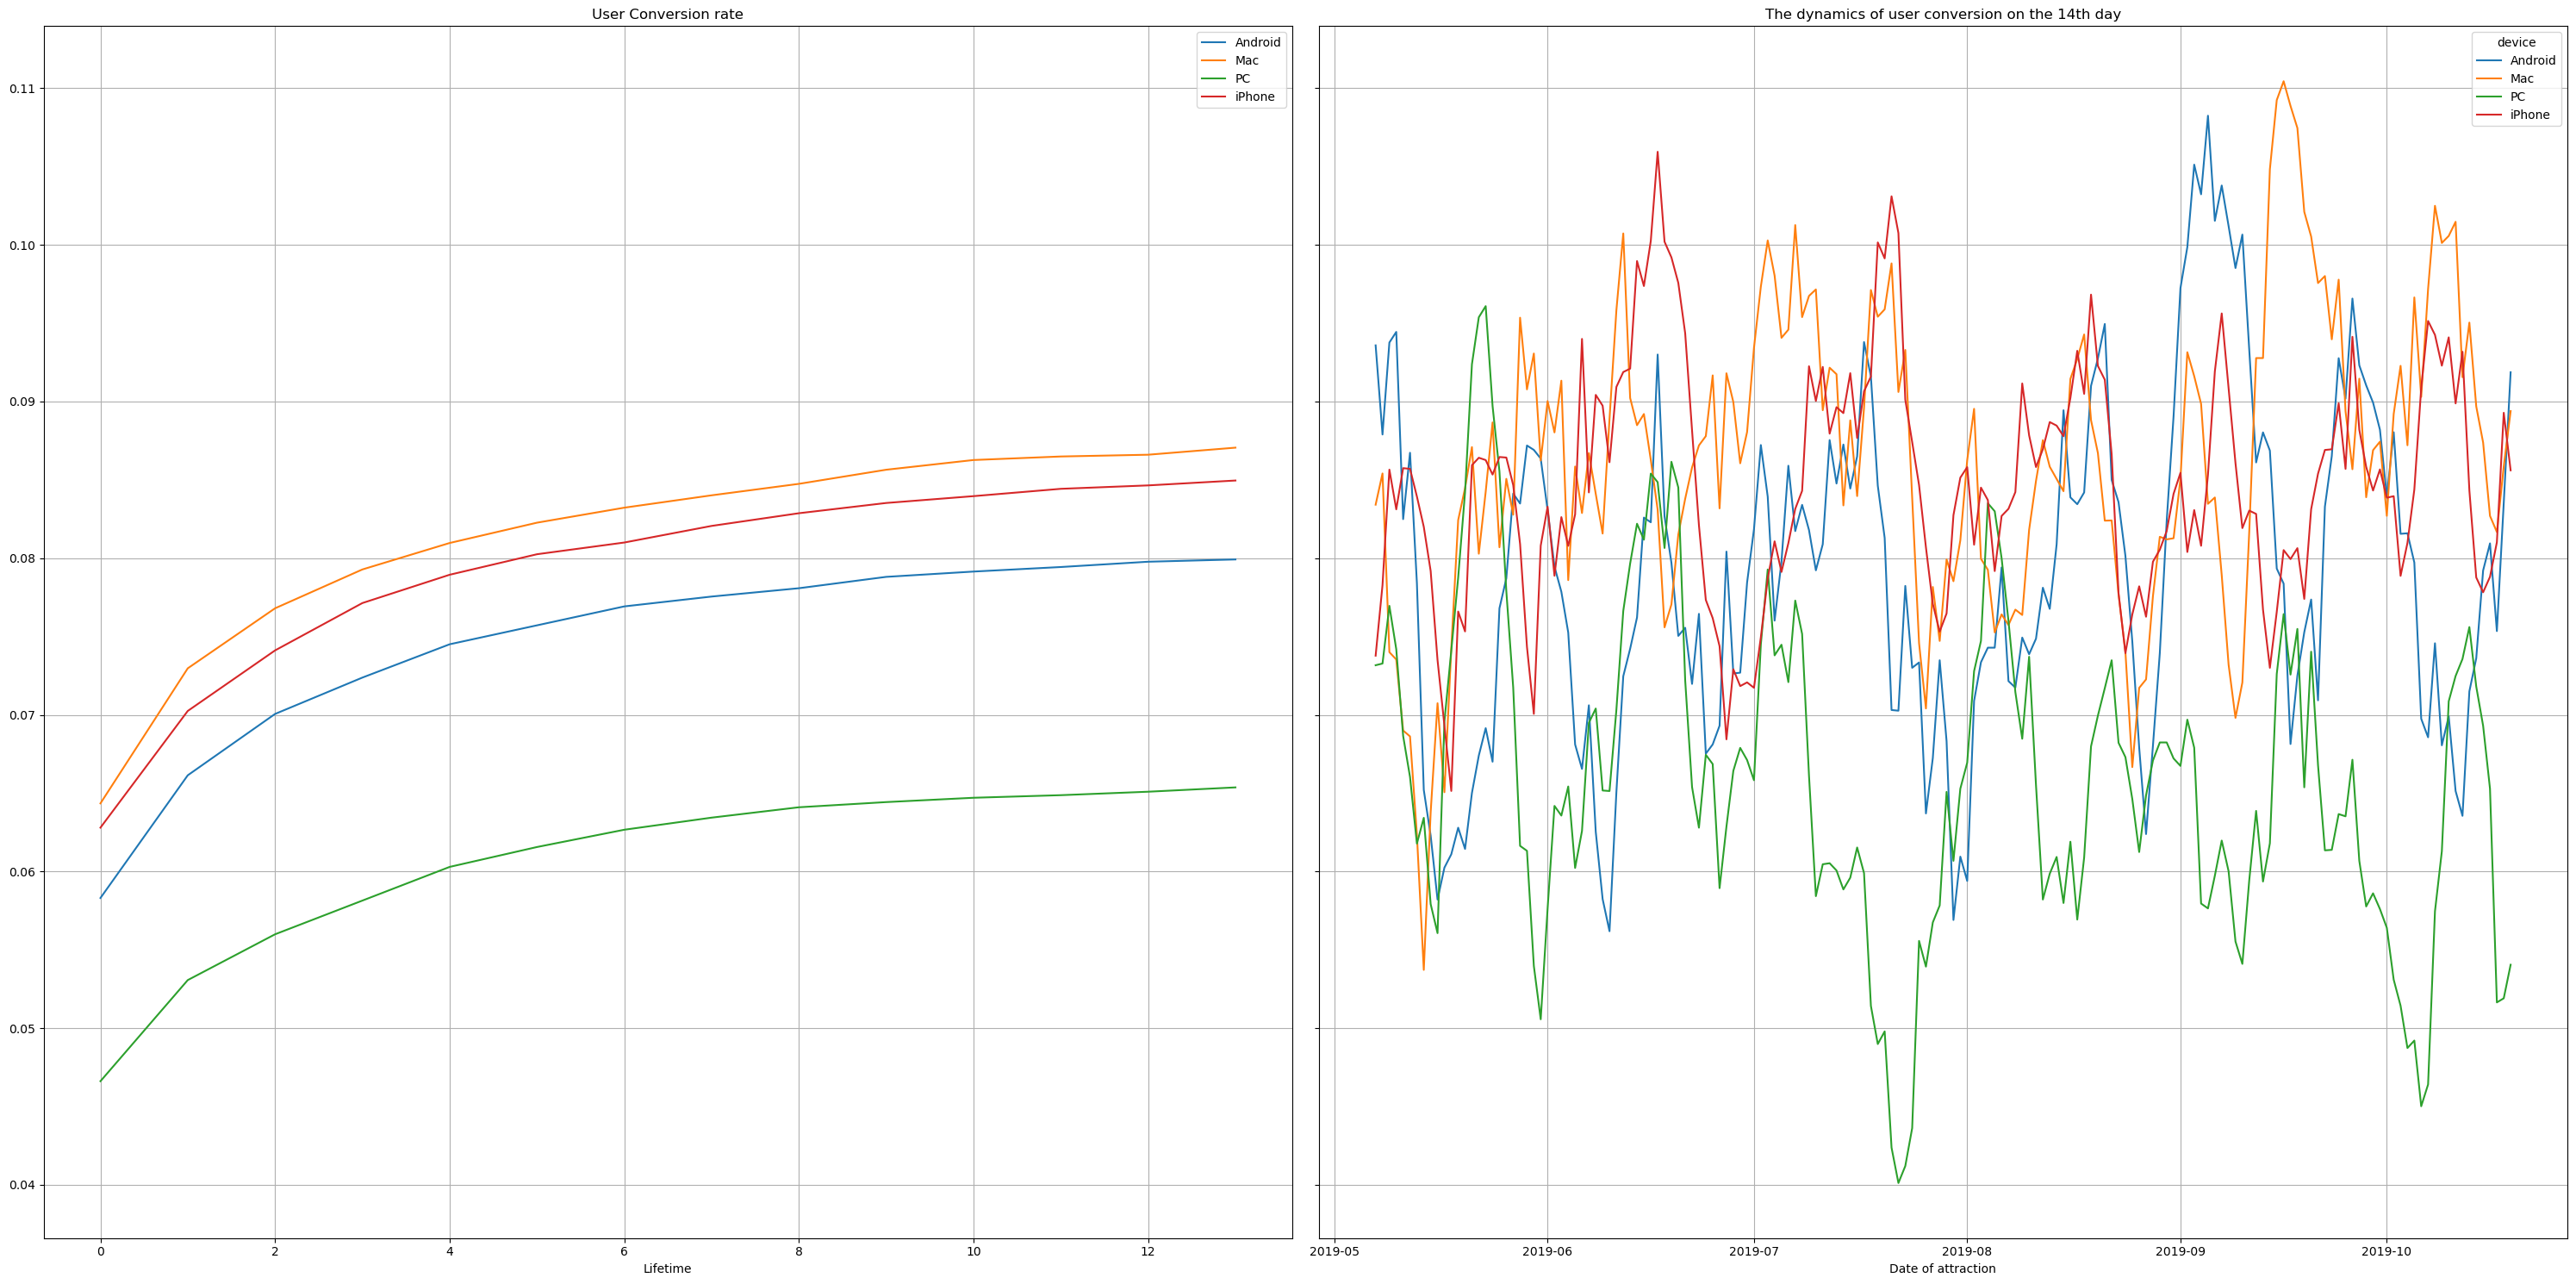

In [53]:
conversion_raw, conversion_grouped, conversion_in_time  = get_conversion(profiles_no_orgnic, orders, observation_date, horizon_days,dimensions = ['device'])

plot_conversion(conversion_grouped, conversion_in_time, horizon_days)

Facebook, LambdaMediaAds and AdNonSense have the best conversion rates through advertising channels. LambdaMediaAds more often than others transfers users to the ranks of those paying during the study period, nevertheless, the schedule is still very chaotic.
By region, the highest conversion rate is in the United States, which again may be due to the fact that the largest number of users come from the United States, but there is also a larger population there.
As previously demonstrated, PC users show the worst results in paying conversions. Most often, iPhone and Mac owners still become paying.
All three graphs show that conversion growth stops at a certain point.

Payback problems can be caused by several factors, but one of them, perhaps the most important, is the incorrect distribution of costs across advertising channels, devices and regions, since using the example of the US region and the TipTop channel, it can be concluded that they receive excessive investments that do not pay off, and which could be sent in a different direction, which could help attract new paying users, that is, entail cost recovery.
Most likely, it was decided to make large investments in those areas that seemed to bring the most paying customers, but perhaps the analysis was not accurate and it was necessary to focus on other areas.

That is, the payback of advertising can be negatively affected by unnecessary investments in advertising in the United States, in the advertising channels TipTop, FaceBoom and advertising on mac and iPhone, android shows slightly controversial results, although advertising also does not overcome the payback level. These areas of advertising take quite a lot of investment, but the return on them is not so good. It is worth reviewing the distribution of funds and considering the potential of other areas.

# Conclusion
Metrics have demonstrated that the work of the marketing department is not performed efficiently enough. Most of the costs are spent on advertising channels, devices and regions that do not bring significant profits to the company in the future. So, regarding advertising channels, FaceBoom and AdNonSense channels invest the largest amount of funds, although they are less successful in retaining paying users than LambdaMediaAds, this channel demonstrates better conversion rates of paying users, retention and payback, and the best LTV indicator in dynamics. For the TipTop channel, it is worth reducing costs, since they grow too fast, which prevents payback, although otherwise this advertising channel shows itself quite well.
Regarding the regions, the largest costs go to the United States, but in this region there are poor payback rates for attracting users, which may simply be due to excessive investments, low retention rates. It is worth paying attention to the UK region, it pays off well, and shows one of the best retention rates for paying customers.
Of the devices, it is worth paying attention to the PC, despite not the best conversion rates, this type of device is still in demand among users, since retention is best done on it, and the costs of it pay off.